# sr-study

Author: Eduardo Oñate Oyaneder

---
## 0) Imports

In [1]:
import matplotlib
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
from typing import List, Union
import os
from bidict import bidict

---
## 1) Defining parameters and basic operations

In [2]:
label_names = [f for f in os.listdir('/home/edu/data/datasets/PCCh23') if os.path.isdir(os.path.join('/home/edu/data/datasets/PCCh23', f))]
label_names = sorted(label_names)
label_nums = [i for i in range(len(label_names))]

LABELS = bidict(zip(label_nums, label_names))  # Bidirectional mapping between label numbers and label names
"""
LABELS = bidict({0: 'Aldo_Valle_Acevedo', 1: 'Alejandro_Kohler_Vargas', ..., 126: 'Yerko_Ljubetic_Godoy'})
"""

EMBS_PER_SHUFFLE = 20

In [3]:
def get_embeddings(file_path: str, min_samples: int = EMBS_PER_SHUFFLE):
    """
    Reads embeddings from a pickle file and returns the label vector, embeddings
    and embeddings grouped by label considering only the speakers with at least m samples.
    """
    data = pickle.load(open(file_path, 'rb'))

    # Store embeddings grouped by label
    embeddings_by_label = {}
    
    # Iterate over the dictionary items
    for key, value in data.items():
        # Parse the key to extract the label
        _, label, _ = key.split('@')

        # If the label is not in the dictionary, add it with an empty list
        if label not in embeddings_by_label:
            embeddings_by_label[label] = []

        # Append the embedding to the correct label list
        embeddings_by_label[label].append(value)

    keys = list(embeddings_by_label.keys())
    keys.sort()
    for label in keys:
        if len(embeddings_by_label[label]) < min_samples:
            del embeddings_by_label[label]  # Remove speakers with less than m samples
    
    
    embeddings = []
    label_vector = []

    for label, emb_list in embeddings_by_label.items():
        # Extend the embeddings list
        embeddings.extend(emb_list)
        # Append the label to the label vector
        label_vector += [LABELS.inv[label]] * len(emb_list)


    return np.array(label_vector), np.array(embeddings), embeddings_by_label

def get_centroid_by_label(embeddings_by_label: dict):
        
    centroids_by_label = {}

    # Calculate centroid for each label
    for label, emb_list in embeddings_by_label.items():
        # Convert list of arrays into a single numpy array
        emb_array = np.array(emb_list)
        # Calculate the mean along axis 0 (mean of each column)
        centroid = np.mean(emb_array, axis=0)
        centroids_by_label[label] = centroid

    return centroids_by_label


In [4]:
def cosine_similarity(vec1, vec2):
    """
    Compute the cosine similarity between two vectors.
    Since embeddings are already normalized, we can use the dot product as the cosine similarity.
    """
    dot_product = np.dot(vec1, vec2)
    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)
    cosine_similarity = dot_product / (norm_vec1 * norm_vec2)
    return (cosine_similarity + 1) / 2  # Normalized cosine similarity

def arccos(x):
    """
    Compute the arccosine of a value in radians.
    """
    cos_theta = 2*x - 1  # De-normalize cosine similarity
    theta = np.arccos(cos_theta)
    return np.degrees(theta)  # Convert radians to degrees

In [5]:
def shuffle_embeddings(subject_embs: np.ndarray, label: int,
                       num_shuffles: int = 100, embeddings_per_shuffle: int = 50) -> np.ndarray:
    """
    Pseudo-randomly shuffles embeddings for a given label.
    """
    base_seed = label
    shuffled_embeddings = np.empty((num_shuffles, embeddings_per_shuffle, subject_embs.shape[1]), 
                                   dtype=subject_embs.dtype)

    for i in range(num_shuffles):
        seed = base_seed + i
        np.random.seed(seed)
        permuted_indices = np.random.permutation(subject_embs.shape[0])[:embeddings_per_shuffle]
        if len(permuted_indices) < embeddings_per_shuffle:
            return None
        shuffled_embeddings[i] = subject_embs[permuted_indices]

    return shuffled_embeddings

def centroid_evolution_by_label(embeddings: np.ndarray, label_vector: np.ndarray, label: int):
    """
    Characterizes the centroid drift for a given label.
    The centroid drift is calculated as the cosine similarity between the centroid of the first n embeddings
    and the centroid of the first n+1 embeddings.
    We use 100 sequences of the embeddings reordenated randomly to avoid any bias.
    """
    indices = np.where(label_vector == label)
    subject_embs = embeddings[indices]

    shuffled_embeddings = shuffle_embeddings(subject_embs, label, num_shuffles=100,
                                              embeddings_per_shuffle=EMBS_PER_SHUFFLE)
    if shuffled_embeddings is None:
        centroids = np.zeros((100, EMBS_PER_SHUFFLE, subject_embs.shape[1]), dtype=np.float32)
        similarities = np.zeros((100, EMBS_PER_SHUFFLE - 1, 1), dtype=np.float32)
        return centroids, similarities
    
    centroids = np.empty(shuffled_embeddings.shape, dtype=shuffled_embeddings.dtype)

    for i in range(shuffled_embeddings.shape[0]):
        embeddings_sequence = shuffled_embeddings[i]
        for j in range(embeddings_sequence.shape[0]):
            embeddings = embeddings_sequence[:j+1]
            cen = np.mean(embeddings, axis=0)
            centroids[i, j] = cen
        
    similarities = np.empty((shuffled_embeddings.shape[0], shuffled_embeddings.shape[1] - 1, 1))
    for i in range(similarities.shape[0]):
        for j in range(similarities.shape[1]):
            cen1 = centroids[i, j]
            cen2 = centroids[i, j+1]
            sim = cosine_similarity(cen1, cen2)
            similarities[i, j] = sim

    return centroids, similarities

In [6]:
def centroid_evolution(label_vector: np.ndarray, embeddings: np.ndarray):
    """
    Computes the centroid evolution for each label. Returns the matrices C, U and V.
    """
    
    centroids = np.empty((len(LABELS), EMBS_PER_SHUFFLE, embeddings.shape[1]), dtype=embeddings.dtype)
    avg_similarities = np.empty((EMBS_PER_SHUFFLE - 1, len(LABELS)), dtype=embeddings.dtype)
    std_similarities = np.empty((EMBS_PER_SHUFFLE - 1, len(LABELS)), dtype=embeddings.dtype)

    for label_num in LABELS:
        centroid_sequences, sim_sequences = centroid_evolution_by_label(embeddings, label_vector, label_num)
        avg_centroid_sequence = np.mean(centroid_sequences, axis=0)
        centroids[label_num] = avg_centroid_sequence
        avg_sim_sequence = np.mean(sim_sequences, axis=0).flatten()
        std_sim_sequence = np.std(sim_sequences, axis=0).flatten()
        avg_similarities[:, label_num] = avg_sim_sequence
        std_similarities[:, label_num] = std_sim_sequence
        

    return centroids, avg_similarities, std_similarities


In [7]:
embeddings_paths = ['/home/edu/embeddings/PCCh23_1_embeddings.pkl',
                    '/home/edu/embeddings/PCCh23_2_embeddings.pkl',
                    '/home/edu/embeddings/PCCh23_5_embeddings.pkl',
                    '/home/edu/embeddings/PCCh23_10_embeddings.pkl',
                    '/home/edu/embeddings/PCCh23_15_embeddings.pkl',
                    '/home/edu/embeddings/PCCh23_30_embeddings.pkl']

label_vector_1, embeddings_1, embeddings_by_label_1 = get_embeddings(embeddings_paths[0])
C_1, U_1, V_1 = centroid_evolution(label_vector_1, embeddings_1)
 
label_vector_2, embeddings_2, embeddings_by_label_2 = get_embeddings(embeddings_paths[1])
C_2, U_2, V_2 = centroid_evolution(label_vector_2, embeddings_2)

label_vector_5, embeddings_5, embeddings_by_label_5 = get_embeddings(embeddings_paths[2])
C_5, U_5, V_5 = centroid_evolution(label_vector_5, embeddings_5)

label_vector_10, embeddings_10, embeddings_by_label_10 = get_embeddings(embeddings_paths[3])
C_10, U_10, V_10 = centroid_evolution(label_vector_10, embeddings_10)

label_vector_15, embeddings_15, embeddings_by_label_15 = get_embeddings(embeddings_paths[4])
C_15, U_15, V_15 = centroid_evolution(label_vector_15, embeddings_15)

label_vector_30, embeddings_30, embeddings_by_label_30 = get_embeddings(embeddings_paths[5])
C_30, U_30, V_30 = centroid_evolution(label_vector_30, embeddings_30)

DURATIONS = [1, 2, 5, 10, 15, 30]
LABEL_VECTORS = [label_vector_1, label_vector_2, label_vector_5, label_vector_10, label_vector_15, label_vector_30]
LABEL_NUMS = [np.unique(label_vector) for label_vector in LABEL_VECTORS]
EMBEDDINGS = [embeddings_1, embeddings_2, embeddings_5, embeddings_10, embeddings_15, embeddings_30]
C = np.array([C_1, C_2, C_5, C_10, C_15, C_30])
U = np.array([U_1, U_2, U_5, U_10, U_15, U_30])
V = np.array([V_1, V_2, V_5, V_10, V_15, V_30])

# Common speakers in all 4 datasets
COMMON_LABELS = list(set(label_vector_1) & set(label_vector_2) & set(label_vector_5) & set(label_vector_10) & set(label_vector_15) & set(label_vector_30))
COMMON_LABELS.sort()

In [8]:
from tabulate import tabulate

data = [
    ['Dataset', 'Num. embeddings', 'Num. speakers'],
    ['1s', embeddings_1.shape[0], len(embeddings_by_label_1)],
    ['2s', embeddings_2.shape[0], len(embeddings_by_label_2)],
    ['5s', embeddings_5.shape[0], len(embeddings_by_label_5)],
    ['10s', embeddings_10.shape[0], len(embeddings_by_label_10)],
    ['15s', embeddings_15.shape[0], len(embeddings_by_label_15)],
    ['30s', embeddings_30.shape[0], len(embeddings_by_label_30)]
]

# Print the table with dashed lines
print(tabulate(data, headers="firstrow", tablefmt="grid"))

+-----------+-------------------+-----------------+
| Dataset   |   Num. embeddings |   Num. speakers |
+===========+===================+=================+
| 1s        |            128177 |             127 |
+-----------+-------------------+-----------------+
| 2s        |            107858 |             127 |
+-----------+-------------------+-----------------+
| 5s        |             67340 |             126 |
+-----------+-------------------+-----------------+
| 10s       |             32585 |             123 |
+-----------+-------------------+-----------------+
| 15s       |             17364 |             107 |
+-----------+-------------------+-----------------+
| 30s       |              4870 |              76 |
+-----------+-------------------+-----------------+


---
## 2) Intraclass Centroid Evolution

### Transient State

In [9]:
def plot_centroid_evolution_by_label(ax: plt.Axes, 
                                     U_sim: np.ndarray,
                                     V_sim: np.ndarray,
                                     duration: List[int],
                                     label: Union[str, int], 
                                     T: int = 10) -> plt.Figure:
    """
    Plots the centroid evolution for a given label in terms of the cosine similarity between
    successive centroids. The plot shows the mean similarity and the standard deviation
    for each segment duration.
    """

    sns.set_style('whitegrid')
    
    idx = np.arange(2, T+2)
    cmap = matplotlib.colormaps['tab20']  # Get the tab20 colormap
    colors = [cmap(i) for i in range(cmap.N)]  # Get all colors from the colormap
    if type(label) == str:
        label = LABELS.inv[label]
    
    for i in range(len(duration)):
        U = U_sim[i][:,label]
        V = V_sim[i][:,label]
        d = duration[i]
        color_mean = colors[(i * 2) % len(colors)]        # Darker color
        color_std = colors[(i * 2 + 1) % len(colors)]  # Lighter color
        ax.errorbar(idx, U[:T],   # 
                    yerr=V[:T], 
                    label=f'{d} seg', 
                    fmt='-', 
                    color=color_mean, 
                    ecolor=color_std, 
                    elinewidth=2, 
                    capsize=4)
             
    

    ax.set_xlabel('Cantidad de audios')
    ax.set_ylabel('Similitud coseno normalizada')
    if type(label) == int or type(label) == np.int64:
        label = LABELS[label]
    ax.set_title(f'Similitud coseno entre centroides con respecto al anterior\n"{label}"')
    ax.legend(loc='lower right')
    
    return ax

def plot_centroid_evolution_by_duration(mean_sim: np.ndarray,
                                        label_vectors: List[np.ndarray],
                                        durations: List[int],
                                        T: int = 10) -> None:
    """
    Plots the centroid evolution for each label in terms of the cosine similarity between
    successive centroids for each segment duration. It shows the mean similarity for each
    label and duration.
    """
    idx = np.arange(2, T+2)
    means = np.empty((len(durations), T))

    sns.set_style('whitegrid')

    for i in range(len(durations)):
        U = mean_sim[i]
        d = durations[i]
        plt.figure(figsize=(7.5, 5))
        plt.title(f'Similitud coseno por hablante entre centroides con respecto al anterior\nSegmentos de {d} seg')
        plt.xlabel('Cantidad de audios por centroide')
        plt.ylabel('Similitud coseno normalizada')
        plt.yticks(np.arange(0.88, 1.005, 0.02))
    
        means_by_label = []
        for n in range(U.shape[1]):
            if n in label_vectors[i]:
                mean_by_label = U[:,n][:T]
                means_by_label.append(mean_by_label)
                plt.plot(idx, mean_by_label)
    
        means_by_label = np.array(means_by_label)
        means[i] = np.mean(means_by_label, axis=0)

    plt.figure(figsize=(7.5, 5))
    plt.title(f'Similitud coseno entre centroides con respecto al anterior\n(promedio usando promedios por clase)')
    plt.xlabel('Cantidad de audios por centroide')
    plt.ylabel('Similitud coseno normalizada')
    plt.yticks(np.arange(0.88, 1.005, 0.02))
    for j in range(means.shape[0]):
        plt.plot(idx, means[j], label=f'{durations[j]} seg')
    plt.legend(loc='lower right')
    plt.show()
    

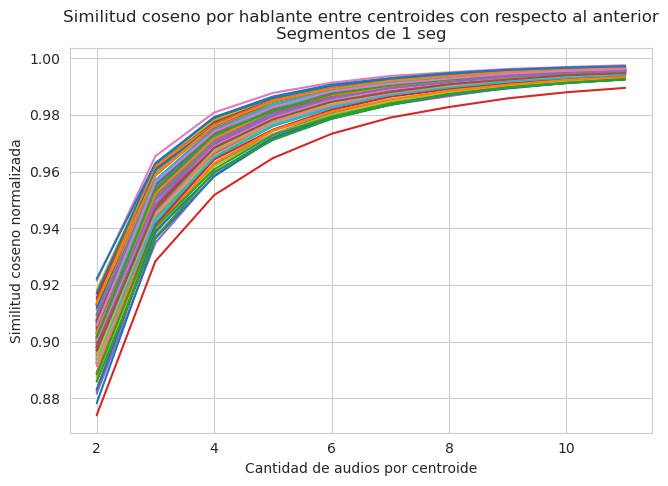

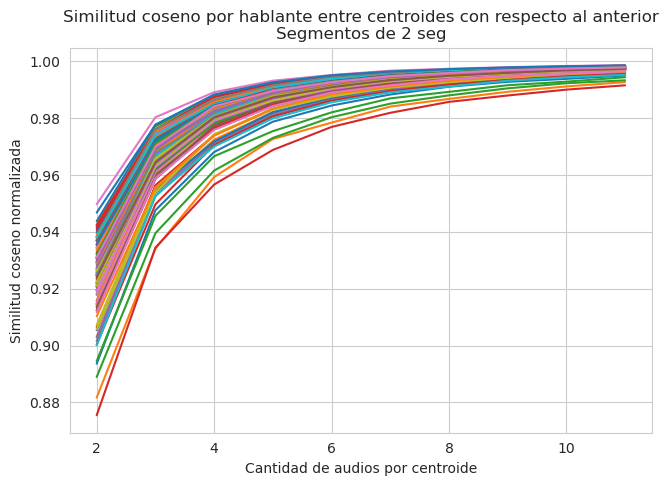

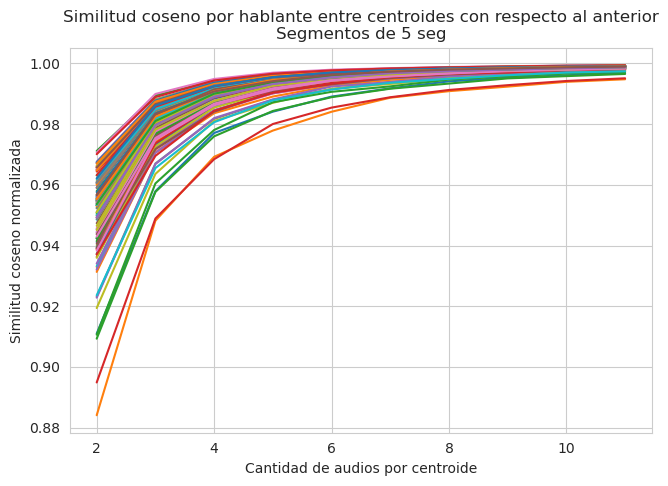

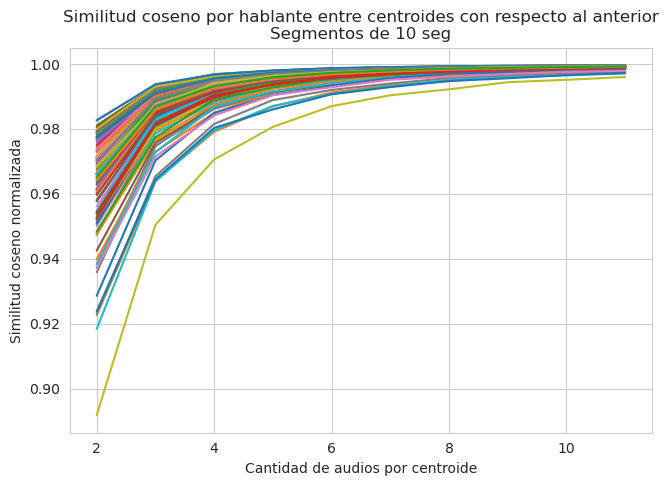

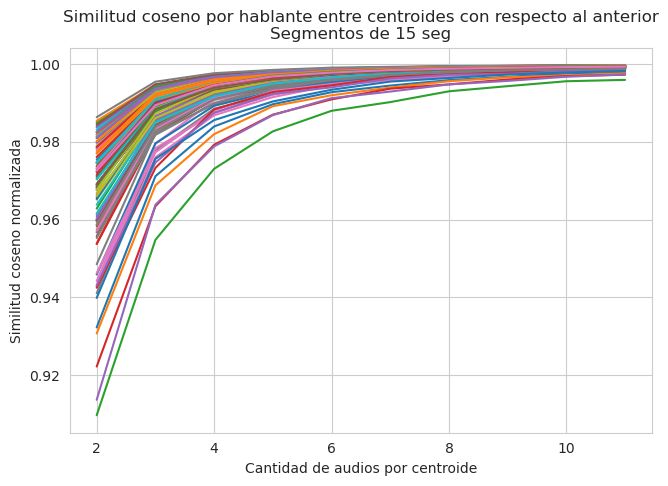

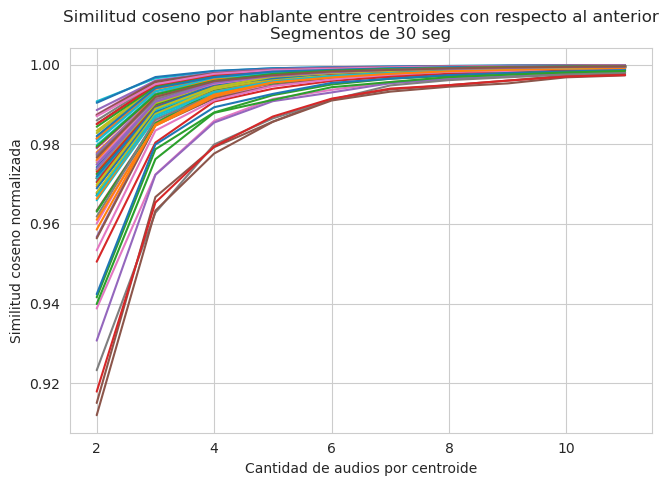

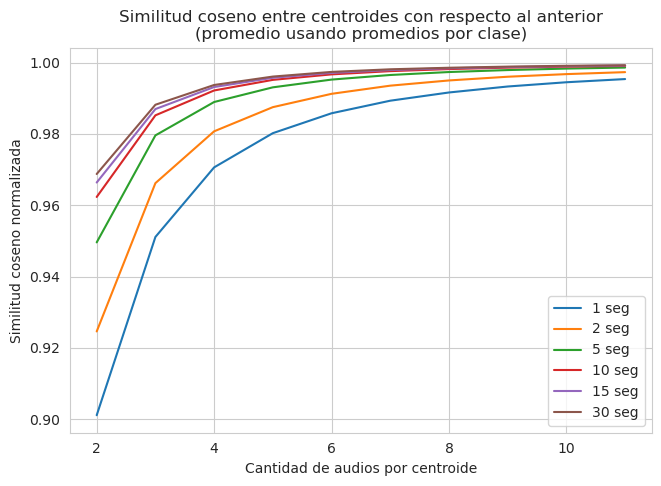

In [10]:
plot_centroid_evolution_by_duration(U, LABEL_VECTORS, DURATIONS, T=10)

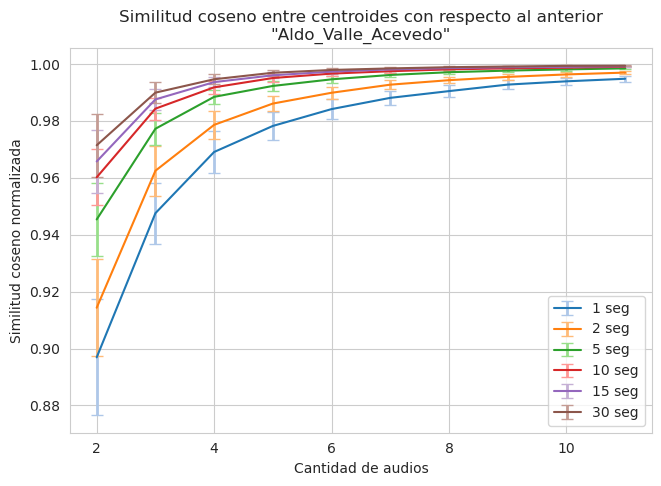

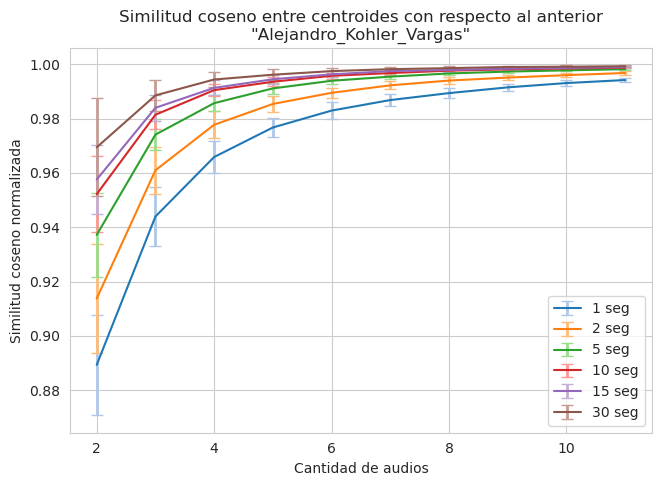

In [11]:
for label in COMMON_LABELS[:2]:
    # Example usage
    fig = plt.figure(figsize=(7.5, 5))
    ax = fig.add_subplot(1, 1, 1)  # Add an Axes to the figure if it doesn't exist
    ax = plot_centroid_evolution_by_label(ax, U, V, DURATIONS, label)

    plt.show()

In [37]:
import warnings

def plot_centroid_kde(means: np.ndarray, k: int):
    """
    Plots a histogram for an element-wise feature in a sequence
    of centroid evolution.
    """
    means = means[:, :, COMMON_LABELS]

    sns.set_style('whitegrid')
    # sns.set_style('white')

    Dur, K_minus_1, N_prime = means.shape
    
    mean = means[:, k, :]
    u = np.array([])
    indexes = np.array([])
    for d in range(Dur):
        u = np.append(u, mean[d])
        indexes = np.append(indexes, np.ones(N_prime, dtype=np.int8) * DURATIONS[d])

    df = pd.DataFrame(dict(u=u, g=indexes))

    # Initialize the FacetGrid object
    pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
    g = sns.FacetGrid(df, row="g", hue="g", aspect=15, height=.5, palette=pal)

    # Draw the densities in a few steps
    g.map(sns.kdeplot, "u",
        bw_adjust=.5, clip_on=False,
        fill=True, alpha=1, linewidth=1.5)
    g.map(sns.kdeplot, "u", clip_on=False, color="w", lw=2, bw_adjust=.5)

    # passing color=None to refline() uses the hue mapping
    g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


    # Define and use a simple function to label the plot in axes coordinates
    def label(x, color, label):
        ax = plt.gca()
        ax.text(0, .2, label, fontweight="bold", color=color,
                ha="left", va="center", transform=ax.transAxes)


    g.map(label, "u")

    # Set the subplots to overlap
    g.figure.subplots_adjust(hspace=.25)

    # Remove axes details that don't play well with overlap
    g.set_titles("")
    g.set(yticks=[], ylabel="")
    g.despine(bottom=True, left=True)

    # Customize x ticks
    custom_ticks = np.linspace(0.86, 1.0, num=8)  # Custom ticks example
    custom_tick_labels = [f"{tick:.2f}" for tick in custom_ticks]

    # Customize x and y ticks
    for ax in g.axes.flat:
        ax.set_xticks(custom_ticks)
        ax.set_xticklabels(custom_tick_labels, size=12)
        ax.xaxis.set_tick_params(which='major', size=7, width=1.5)
        ax.xaxis.set_tick_params(which='minor', size=4, width=1)

    
    # Set a common title for the plot
    g.figure.suptitle(f'Distribución estimada de similitud coseno entre centroides {k+1} y {k+2}', fontsize=14)
    
    # Set a common x-axis label
    g.set_axis_labels("Similitud coseno normalizada", "")

     # Set a common y-axis label
    # g.set_axis_labels("", "Duración del segmento (segundos)")
    
    plt.show()
    return df

# Suppress specific warnings
warnings.filterwarnings("ignore", message=".*tight_layout cannot make axes height.*")
    

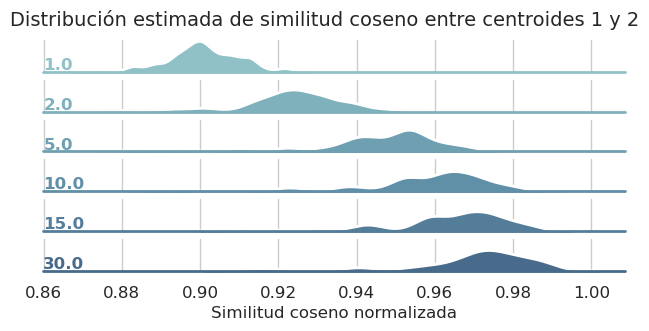

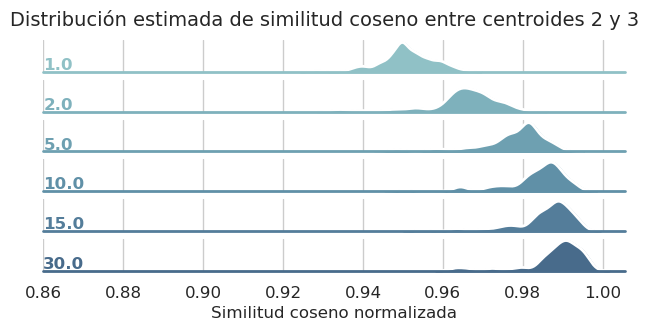

In [40]:
for k in range(2):
    plot_centroid_kde(U, k)

In [15]:
def plot_centroid_evolution_histogram(means: np.ndarray, stds: np.ndarray):
    """
    Plots a histogram for an element-wise feature in a sequence
    of centroid evolution.
    """
    means = means[:, :, COMMON_LABELS]
    max_mean = 1
    min_mean = np.min(means)
    bins_mean = np.linspace(min_mean, max_mean, 25)

    stds = stds[:, :, COMMON_LABELS]
    max_std = np.max(stds)
    min_std = 0
    bins_std = np.linspace(min_std, max_std, 25)

    # sns.set_style('whitegrid')
    sns.set_style('white')

    _, K, _ = means.shape
    for k in range(K):
        mean = means[:, k, :]
        std = stds[:, k, :]
        
        # Plot histograms
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

        title = f"""Histogramas de la media y desviación estándar de la similitud coseno
        entre centroides {k+2} y {k+1}"""

        fig.suptitle(title)
        
        # Mean histogram
        ax1.set_title('Media')
        ax1.hist(mean[0], bins=bins_mean, alpha=0.5, label='1 seg', color='gray')
        ax1.hist(mean[1], bins=bins_mean, alpha=0.5, label='2 seg', color='yellow')
        ax1.hist(mean[2], bins=bins_mean, alpha=0.5, label='5 seg', color='blue')
        ax1.hist(mean[3], bins=bins_mean, alpha=0.5, label='10 seg', color='red')
        ax1.hist(mean[4], bins=bins_mean, alpha=0.5, label='15 sec', color='green')
        ax1.hist(mean[5], bins=bins_mean, alpha=0.5, label='30 seg', color='purple')
        
        ax1.set_xlabel('Media')
        ax1.set_ylabel('Frecuencia')
        ax1.legend(loc='upper left')


        # Standard deviation histogram
        ax2.set_title('Desviación estándar')
        ax2.hist(std[0], bins=bins_std, alpha=0.5, label='1 seg', color='gray')
        ax2.hist(std[1], bins=bins_std, alpha=0.5, label='2 seg', color='yellow')
        ax2.hist(std[2], bins=bins_std, alpha=0.5, label='5 seg', color='blue')
        ax2.hist(std[3], bins=bins_std, alpha=0.5, label='10 seg', color='red')
        ax2.hist(std[4], bins=bins_std, alpha=0.5, label='15 sec', color='green')
        ax2.hist(std[5], bins=bins_std, alpha=0.5, label='30 seg', color='purple')

        ax2.set_xlabel('Desviación estándar')
        ax2.set_ylabel('Frecuencia')
        ax2.legend(loc='upper right')

        # Showing plot
        plt.show()
        
    return bins_mean, bins_std

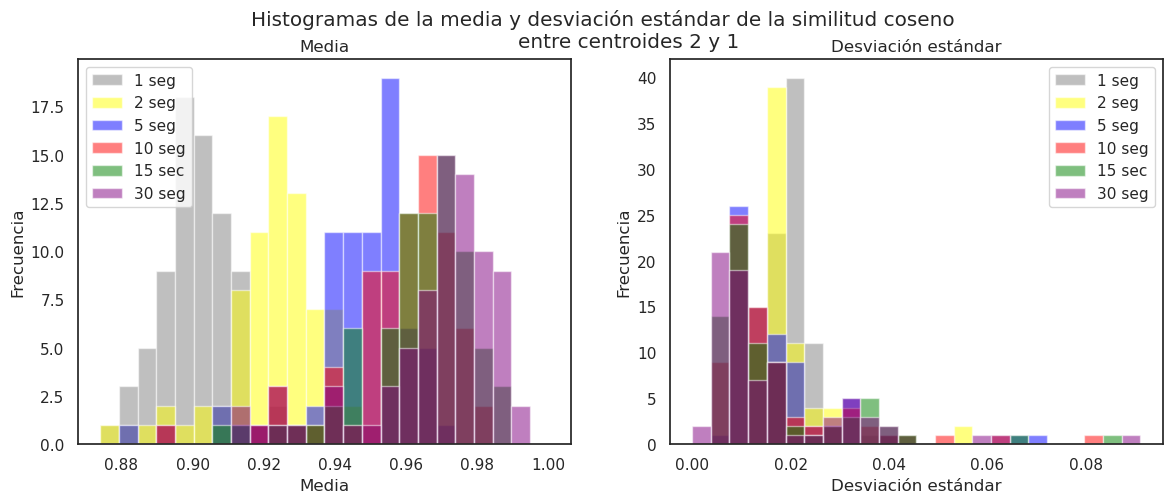

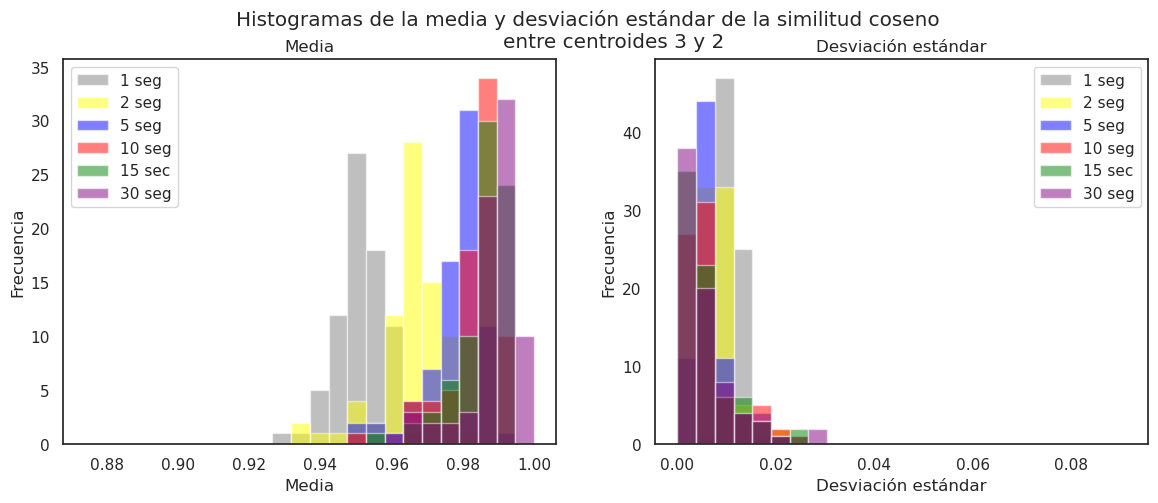

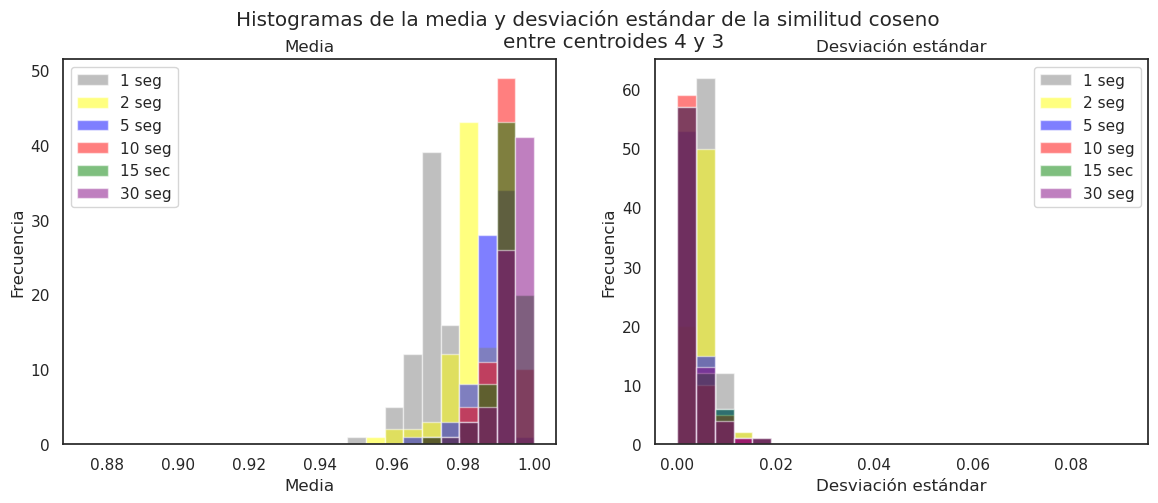

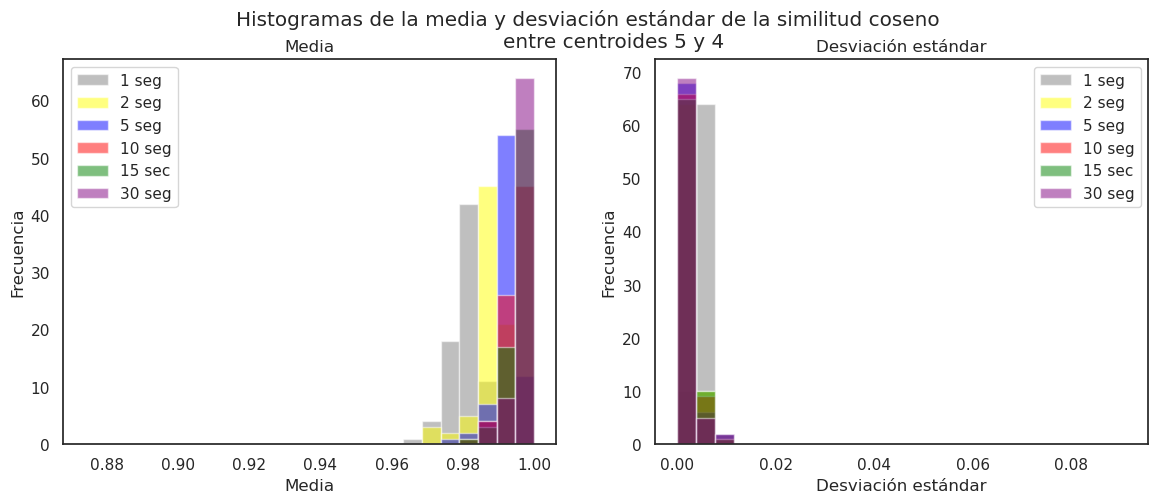

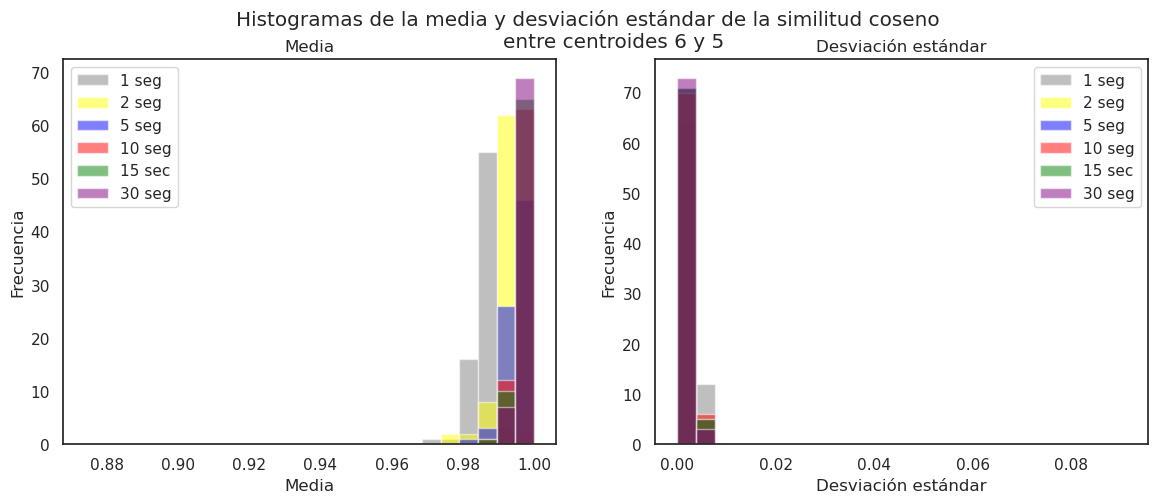

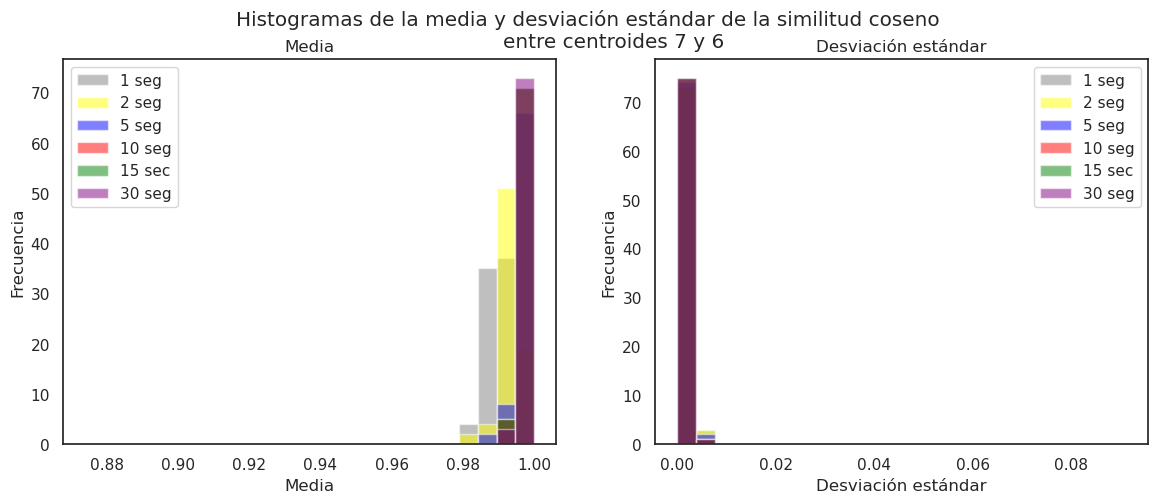

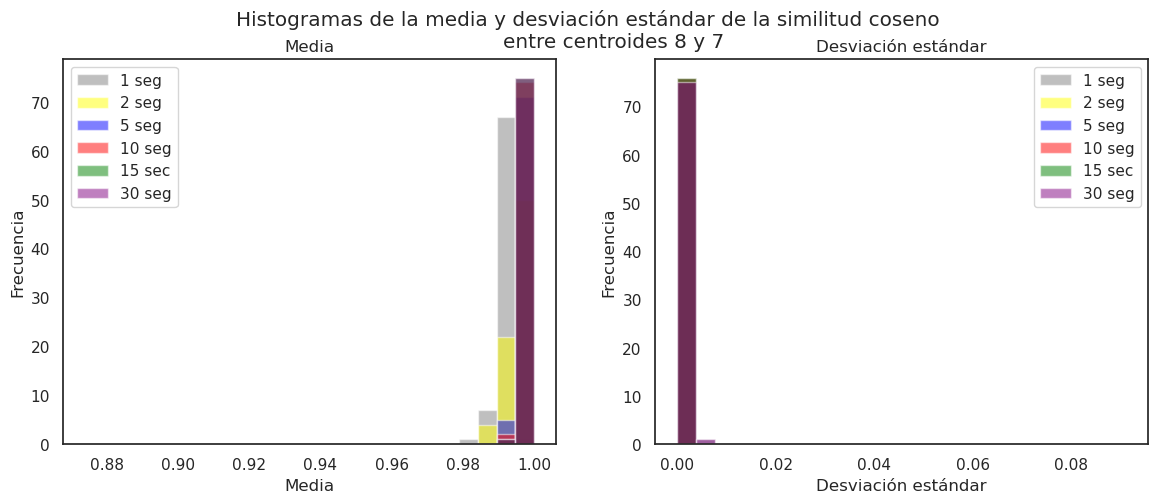

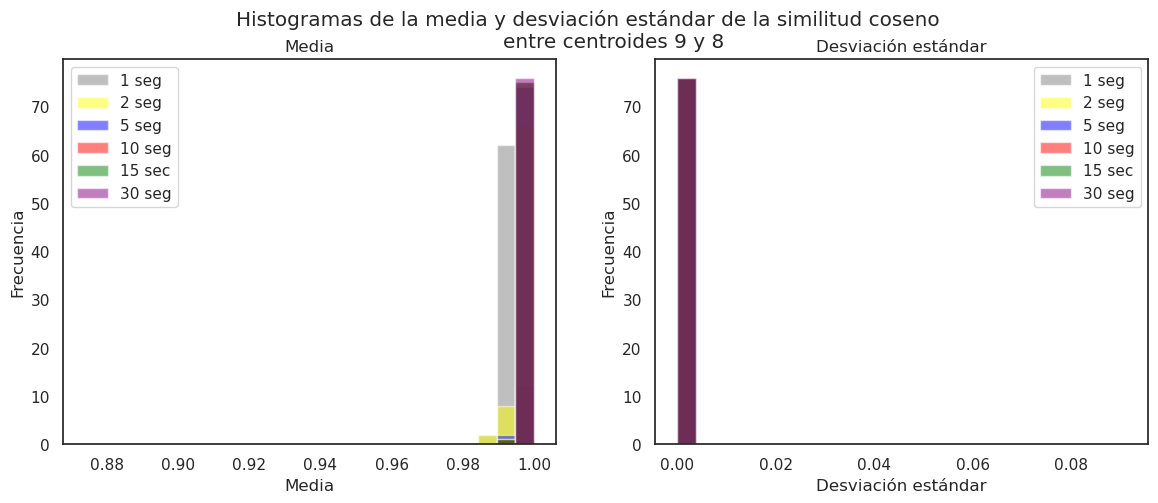

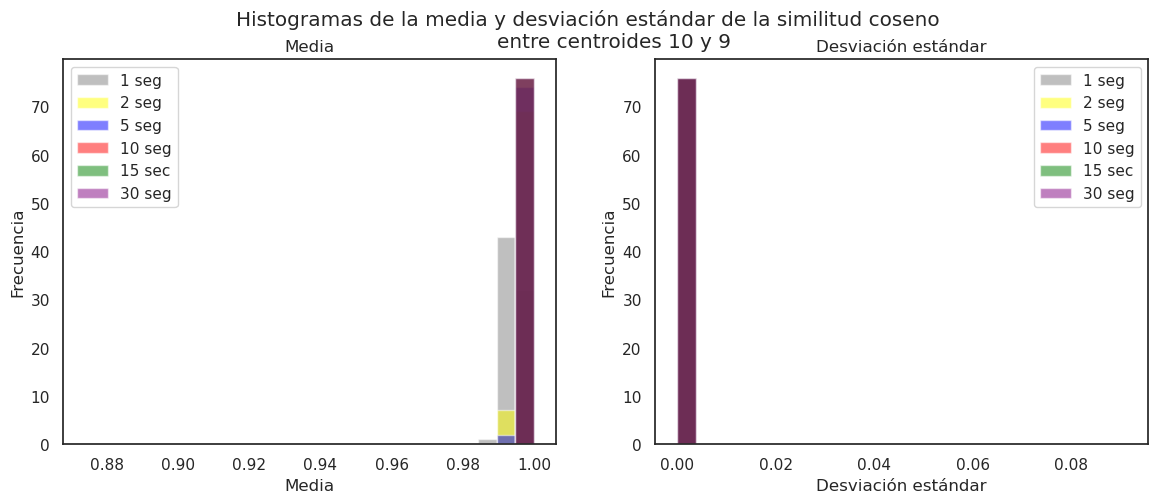

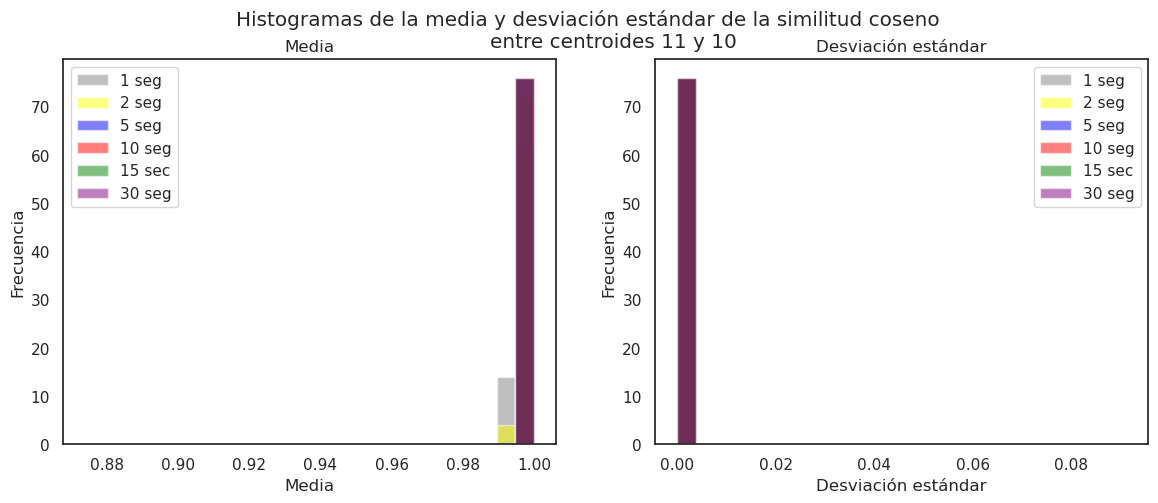

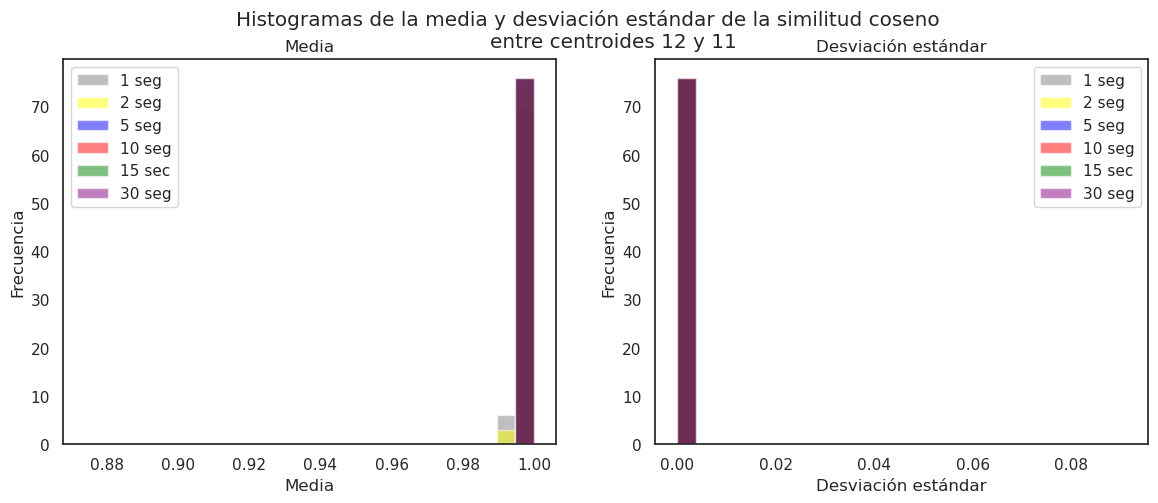

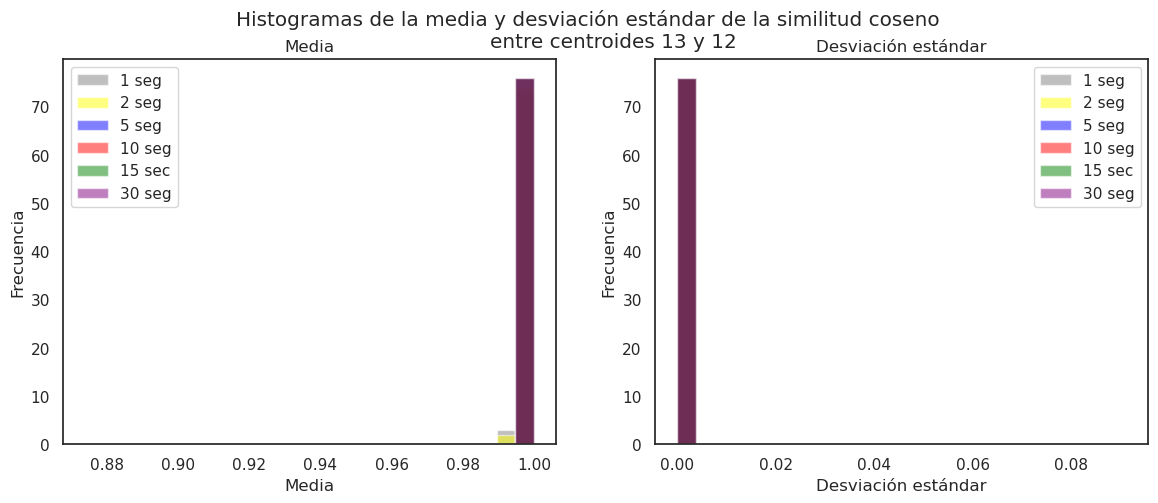

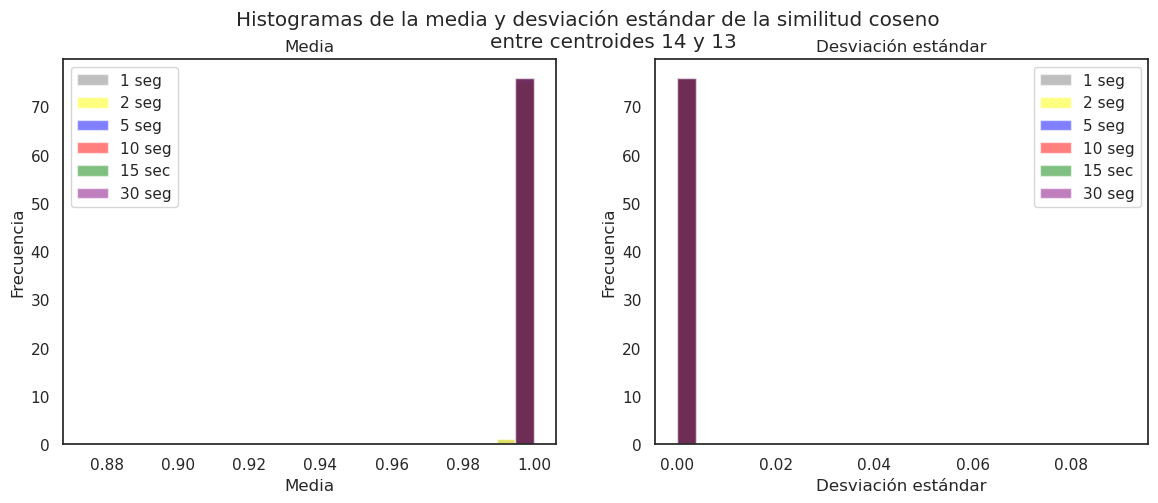

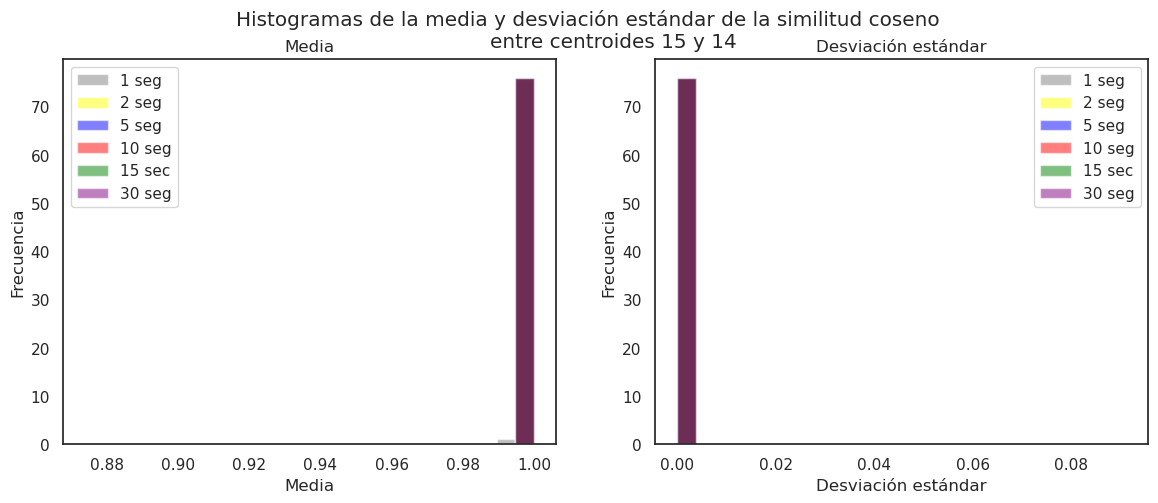

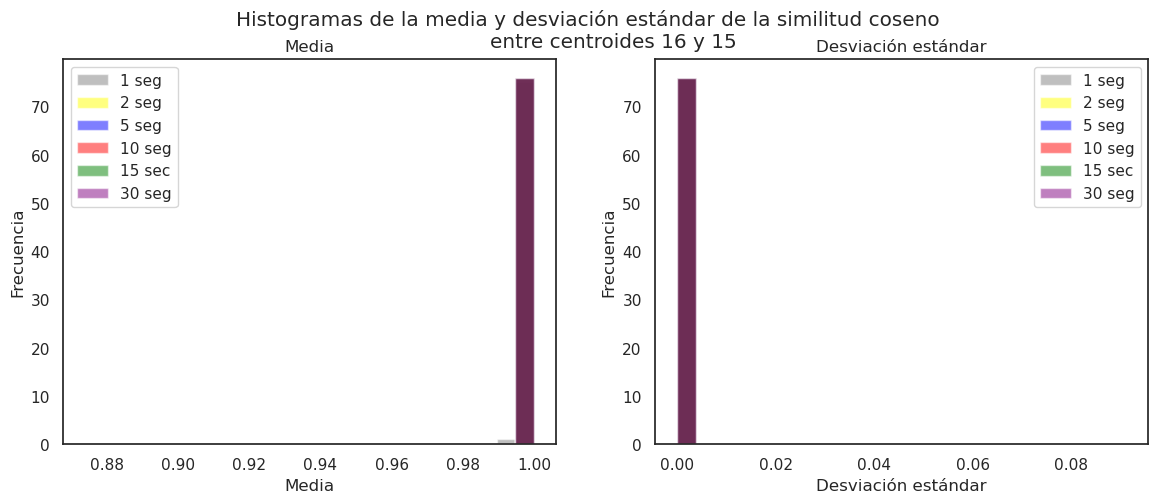

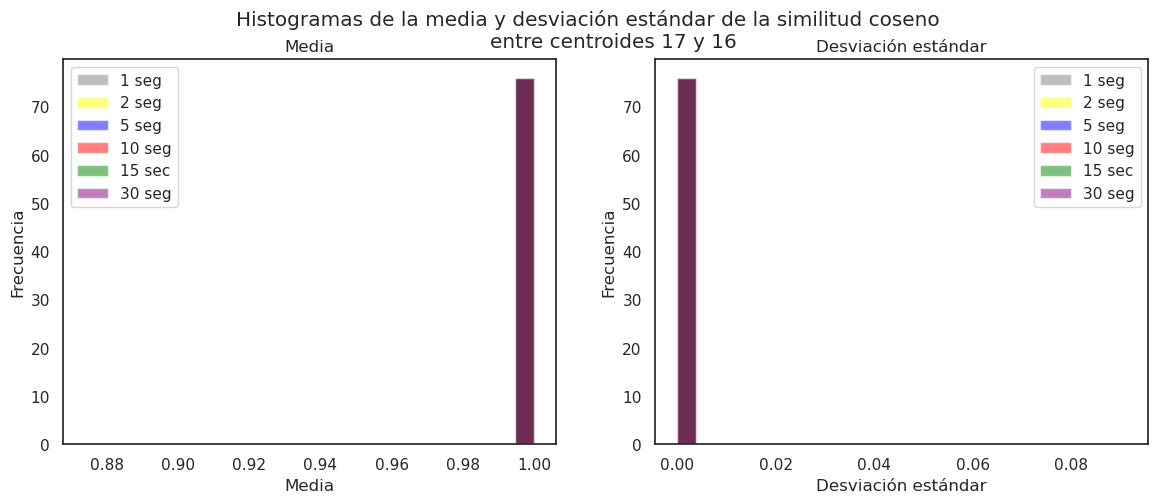

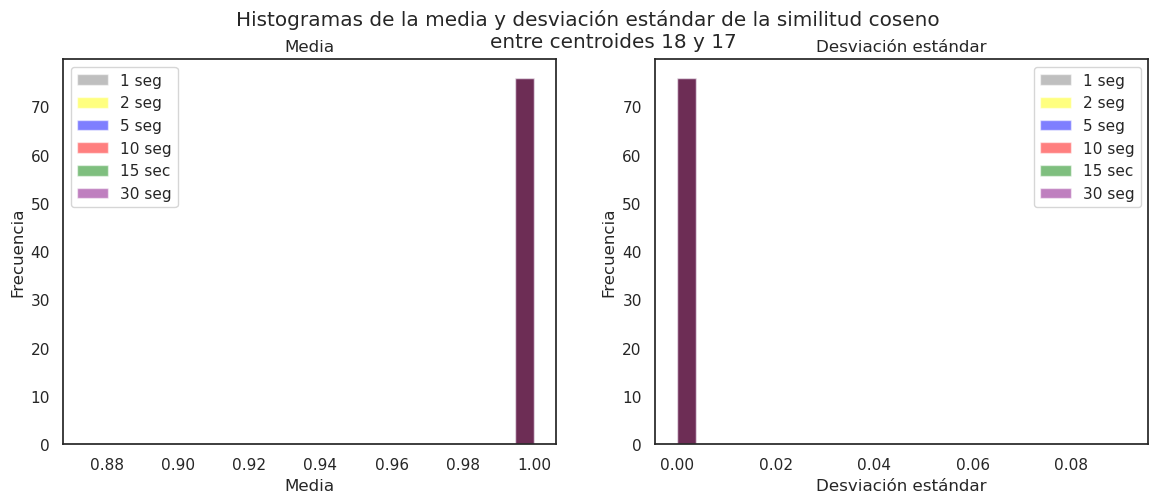

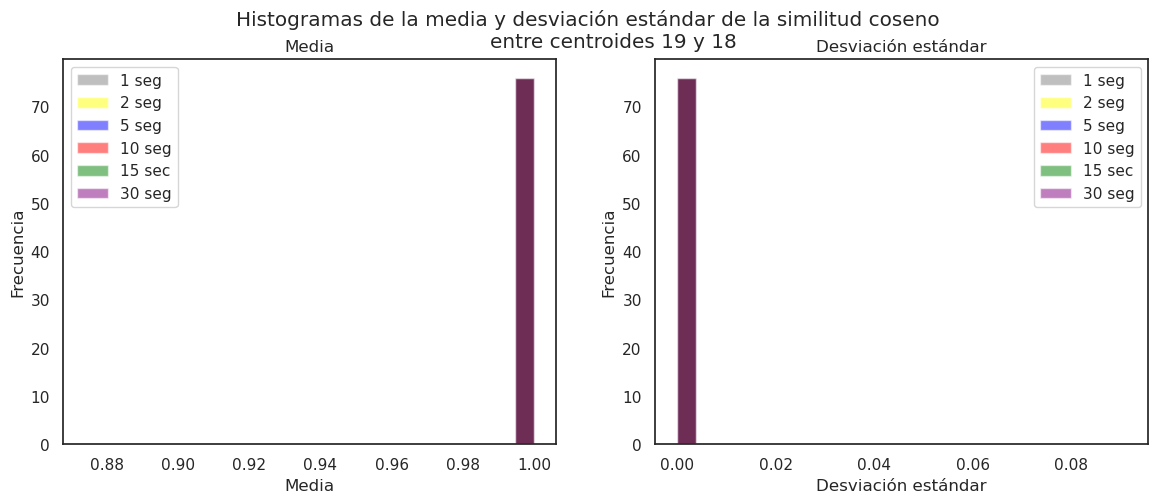

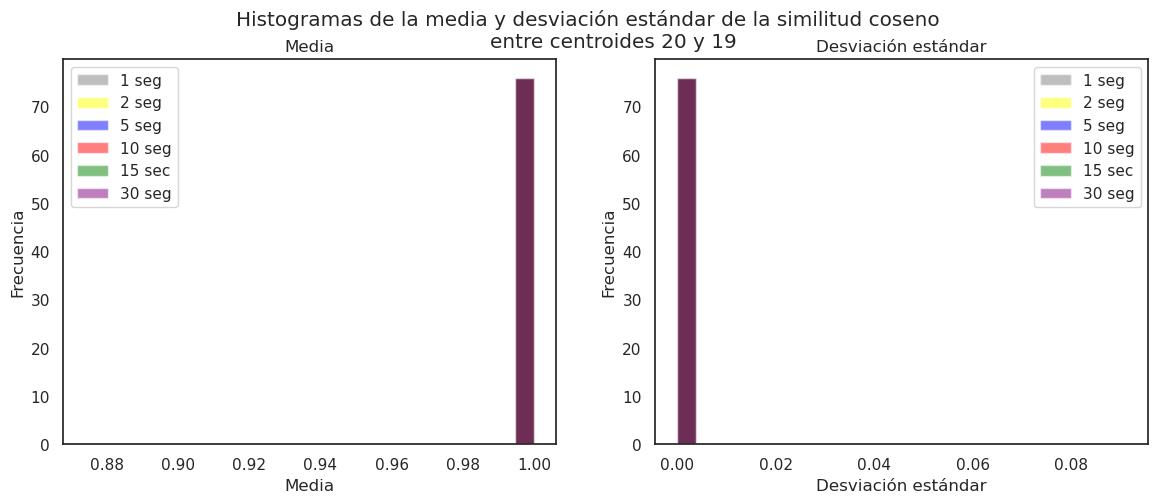

(array([0.87403452, 0.87928309, 0.88453165, 0.88978021, 0.89502877,
        0.90027733, 0.90552589, 0.91077445, 0.91602302, 0.92127158,
        0.92652014, 0.9317687 , 0.93701726, 0.94226582, 0.94751438,
        0.95276295, 0.95801151, 0.96326007, 0.96850863, 0.97375719,
        0.97900575, 0.98425432, 0.98950288, 0.99475144, 1.        ]),
 array([0.        , 0.00379437, 0.00758875, 0.01138312, 0.0151775 ,
        0.01897187, 0.02276625, 0.02656062, 0.030355  , 0.03414937,
        0.03794375, 0.04173812, 0.04553249, 0.04932687, 0.05312124,
        0.05691562, 0.06070999, 0.06450437, 0.06829874, 0.07209312,
        0.07588749, 0.07968187, 0.08347624, 0.08727062, 0.09106499]))

In [16]:
plot_centroid_evolution_histogram(U,V)

### Stationary State

In [17]:
def compare_last_centroids_by_duration(centroids: np.ndarray, duration: List[int]):
    """
    
    """
    last_centroids = np.empty((len(LABELS), len(duration), 192))
    for i in COMMON_LABELS:
        for d in range(len(centroids)):
            last_centroids[i][d] = centroids[d][i][-1]

    Sc_stationary = np.empty((len(LABELS), len(duration), len(duration)))
    for i in COMMON_LABELS:
        for j in range(len(duration)):
            for k in range(len(duration)):
                Sc_stationary[i][j][k] = cosine_similarity(last_centroids[i][j], last_centroids[i][k])

    return Sc_stationary

def plot_last_centroids_similarity(Sc_stationary: np.ndarray, durations: List[int], n: int = None):
    """
    
    """
    sns.set_style('white')
    mask = np.triu(np.ones_like(Sc_stationary[0], dtype=bool))
    durations_s = [f"{d} seg" for d in durations]

    for i, label in enumerate(COMMON_LABELS):
        if n is not None and i >= n:
            break
        plt.figure(figsize=(7.5, 5))
        plt.title(f'Similitud coseno entre centroides finales\n"{LABELS[label]}"')
        sns.heatmap(Sc_stationary[label], cmap="viridis",
                    cbar_kws={'label': 'Similitud coseno normalizada'},
                    square=True, mask=mask,
                    xticklabels=durations_s, yticklabels=durations_s,
                    vmin=0.7, vmax=1)
        plt.show()

def hist_last_centroids_similarity(Sc_stationary: np.ndarray):
    """
    
    """
    sims = []
    mask = np.triu(np.ones_like(Sc_stationary[0], dtype=bool) ^ np.eye(6, dtype=bool))
    for i in COMMON_LABELS:
        sims.append(Sc_stationary[i][mask])  # Append all pairs of similarities
    sims = np.array(sims).flatten()
    
    # Calculate the histogram
    counts, bins = np.histogram(sims, bins=np.arange(0.65, 1.01, 0.025))
    
    # Calculate percentages
    percentages = counts / np.sum(counts) * 100
    
    sns.set_style('whitegrid')
    
    # Linear scale histogram with percentages
    plt.figure(figsize=(8, 5))
    plt.title(f'Histograma de similitud coseno entre centroides finales\nde un mismo hablante para distintas duraciones\n(Escala lineal)')
    plt.xlabel('Similitud coseno normalizada')
    plt.ylabel('Frecuencia')
    
    plt.bar(bins[:-1], counts, width=0.025, align='edge', alpha=0.6, label='Escala lineal')
    
    for bin_edge, cnt, pct in zip(bins[:-1], counts, percentages):
        plt.text(bin_edge + 0.0125, cnt, f'{pct:.2f}%', ha='center', va='bottom', fontsize=8)
    
    plt.show()

    # Log scale histogram
    plt.figure(figsize=(8, 5))
    plt.title(f'Histograma de similitud coseno entre centroides finales\nde un mismo hablante para distintas duraciones\n(Escala logarítmica)')
    plt.xlabel('Similitud coseno normalizada')
    plt.ylabel('log10(Frecuencia)')

    counts_log = counts.copy()
    counts_log[counts_log == 0] = 1  # Avoid calculation of log(0)

    plt.bar(bins[:-1], np.log10(counts_log), width=0.025, align='edge', alpha=0.6, label='Escala logarítmica')
    # plt.stairs(, bins, fill=True, alpha=0.5)  # Plot the histogram in log scale
    plt.show()
    
    return sims, counts, bins

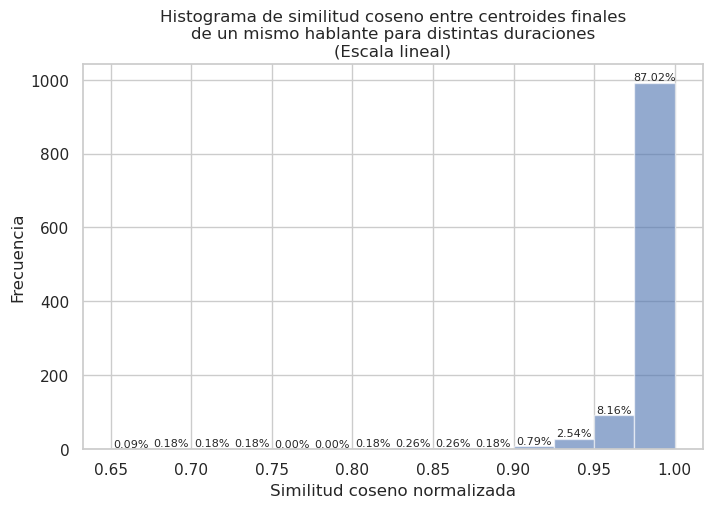

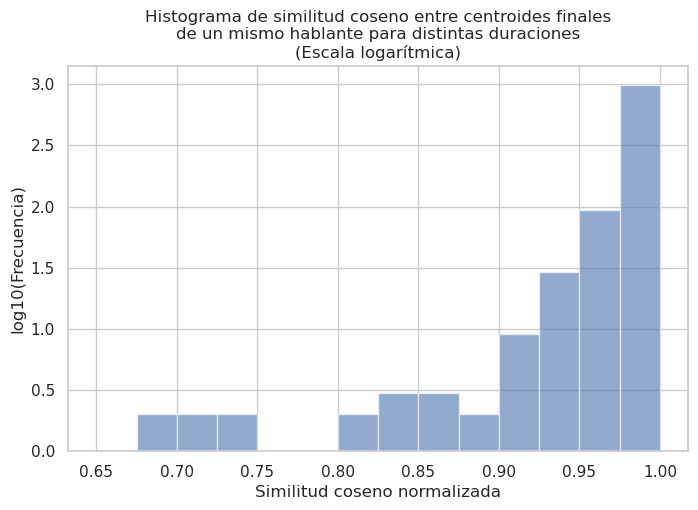

In [18]:
Sc_stationary = compare_last_centroids_by_duration(C, DURATIONS)
sims, counts, bins = hist_last_centroids_similarity(Sc_stationary)

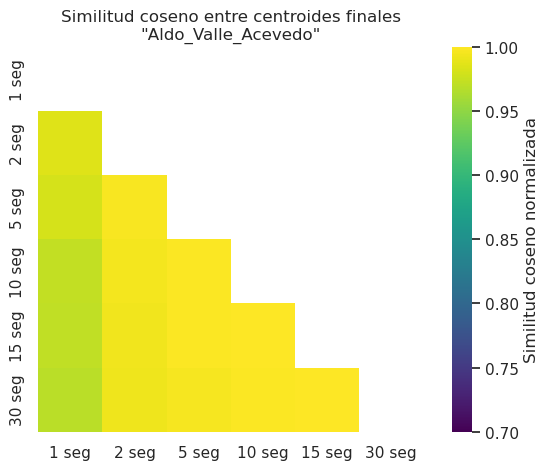

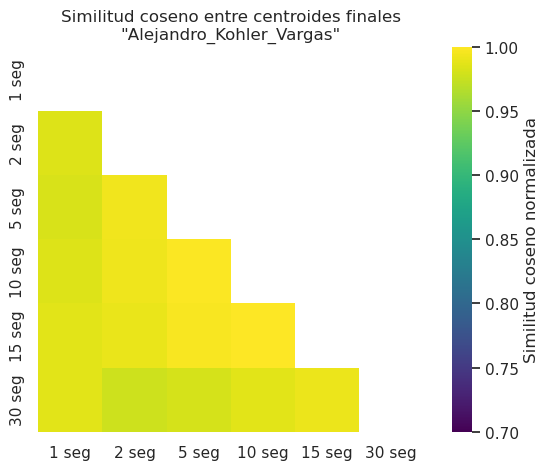

In [19]:
plot_last_centroids_similarity(Sc_stationary, DURATIONS, 2)

In [20]:
# male = [
#  'Alejandro_Kohler_Vargas',
#  'Alihuen_Antileo_Navarrete',
#  'Carlos_Frontaura_Rivera',
#  'Diego_Vargas_Castillo',
#  'Domingo_Lovera_Parmo',
#  'Fernando_Viveros_Reyes',
#  'Hector_Urban_Astete',
#  'Invitado_Carlos_Mora',
#  'Invitado_Claudio_Alvarado',
#  'Invitado_Claudio_Orrego',
#  'Invitado_Enrique_Navarro_Beltran',
#  'Invitado_Gabriel_Bocksang',
#  'Invitado_Gonzalo_Garcia',
#  'Invitado_Javier_Coussot_Salas',
#  'Invitado_Jose_Montt',
#  'Invitado_Juan_Ignacio_Gonzalez',
#  'Invitado_Leonardo_Moreno',
#  'Invitado_Mijail_Bonito',
#  'Invitado_Nicolas_Enteiche',
#  'Invitado_Pablo_Aranda',
#  'Jaime_Arancibia_Mattar',
#  'Jorge_Ossandon_Spoerer',
#  'Luis_Silva_Irarrazaval',
#  'Maximo_Francisco_Pavez_Cantillano',
#  'Miguel_Littin_Cucumides',
#  'Miguel_Rojas_Soto',
#  'Sebastian_Figueroa_Melo',
#  'Secretario_Reynaldo_Nunez',
#  'Yerko_Ljubetic_Godoy']

# female = [
#  'Antonia_Rivas_Palma',
#  'Beatriz_Hevia_Willer',
#  'Carmen_Montoya_Mayorga',
#  'Carolina_Navarrete_Rubio',
#  'Catalina_Adriana_Lagos_Tschorne',
#  'Invitada_Antonia_Polanco',
#  'Invitada_Carmen_Dominguez',
#  'Invitada_Cecilia_Jara',
#  'Invitada_Giannina_Mondino',
#  'Invitada_Javiera_Diaz',
#  'Invitada_Josefa_Balmaceda',
#  'Invitada_Lidia_Casas',
#  'Invitada_Paola_Vega',
#  'Invitada_Rosario_Vidal',
#  'Ivonne_Mangelsdorff_Galeb',
#  'Karen_Araya_Rojas',
#  'Katherine_Denisse_Martorell_Awad',
#  'Kinturay_Melin_Rapiman',
#  'Leslie_Sanchez_Lobos',
#  'Lorena_Gallardo_Cardenas',
#  'Magaly_Fuenzalida_Colombo',
#  'Marcela_Araya_Sepulveda',
#  'Marcela_Ines_Peredo_Rojas',
#  'Maria_Gatica_Gajardo',
#  'Maria_de_los_Angeles_Lopez_Porfiri',
#  'Mariela_Fincheira_Massardo',
#  'Secretaria_Maria_Soledad_Fredes',
#  'Veronica_Undurraga_Valdes']

In [21]:
# plt.figure(figsize=(7.5, 5))
# plt.plot([3], [0.99], label='Masculino', c='orange')
# plt.plot([3], [0.99], label='Femenino',c='purple')
# for label in common_labels:
#     color = 'orange' if label in male else 'purple'
#     plt.plot(idx[:16], sims_df[f'{label}_mean'][:16], color, alpha=0.8)
#     plt.xlabel('Cantidad de audios')
#     plt.ylabel('Similitud coseno normalizada')
#     plt.title(f'Similitud coseno entre centroides sucesivos')
#     plt.legend(title='Género', loc='lower right')

---
## 3) Interclass Centroid Evolution

In [23]:
def get_interclass_similarities(centroids: np.ndarray, label_nums: List[int]):
    """
    Computes the cosine similarity between the centroids of different classes for
    each of the K iterations.
    """
    centroids = centroids[label_nums]  # Get centroids of valid classes for each duration
    N, K, _ = centroids.shape  # N speakers, K iterations, D dimensions
    interclass_similarities = np.zeros((K, N, N))


    for k in range(K):
        centroids_k = centroids[:, k]
        for i in range(N):
            for j in range(N):
                sim = cosine_similarity(centroids_k[i], centroids_k[j])
                interclass_similarities[k, i, j] = sim

    return interclass_similarities

def plot_max_interclass_similarity(interclass_similarities: List[np.ndarray]):
    """
    Plots the maximum interclass similarity for each iteration.
    """
    sns.set_style('whitegrid')
    plt.figure(figsize=(7.5, 5))
    plt.title('Máxima diferencia entre similitudes coseno de centroides interclase por iteración\ncon respecto a la anterior')
    plt.xlabel('Cantidad de audios')
    plt.ylabel('Diferencia máxima (valor absoluto)')

    K = interclass_similarities[0].shape[0]
    
    for i in range(len(interclass_similarities)):
        inter_sim = interclass_similarities[i]
        
        # Calculate the maximum difference between each pair of iterations
        maximums = []
        for k in range(K-1):
            m = np.max(abs(inter_sim[k] - inter_sim[k+1]))
            maximums.append(m)
        plt.plot(np.arange(2, K+1), maximums, label=f'{DURATIONS[i]} seg')
    
    plt.xticks(np.arange(2, K+1, 2))
    plt.legend()
    plt.show()

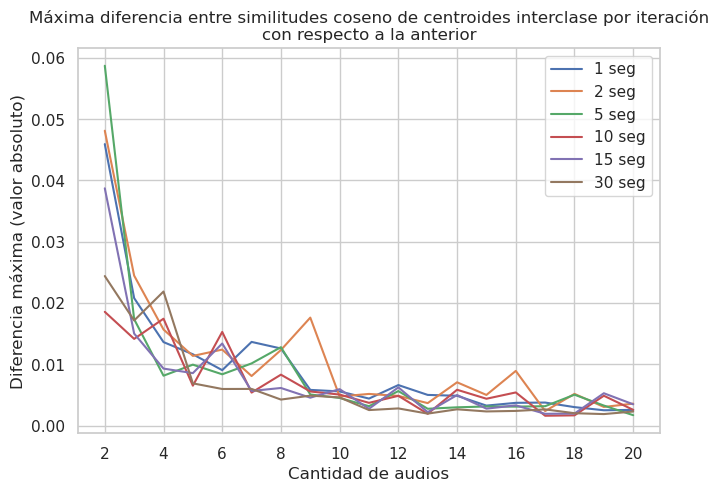

In [24]:
interclass_similarities = []
for i in range(len(C)):    
    interclass_similarities.append(get_interclass_similarities(C[i], LABEL_NUMS[i]))

plot_max_interclass_similarity(interclass_similarities)
    

In [65]:
def plot_intercentroid_sim_kde(interclass_similarities: np.ndarray, k: int):
    """
    Plots a histogram for an element-wise feature in a sequence
    of centroid evolution.
    """
    sims = np.array([])
    indexes = []
    for d, inter_sim in enumerate(interclass_similarities):
        K, N, _ = inter_sim.shape
        mask = np.triu(np.ones(N, dtype=bool) ^ np.eye(N, dtype=bool))
        last_inter_sim = inter_sim[k]  # Interclass similarities of centroids calculated with k audios
        last_inter_sim = last_inter_sim[mask]
        sims = np.append(sims, last_inter_sim)
        indexes.extend([str(DURATIONS[d])] * len(last_inter_sim))
        
    df = pd.DataFrame(dict(x=sims, g=indexes))

    # return df

    sns.set_style('whitegrid')
    # sns.set_style('white')

    # Initialize the FacetGrid object
    pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
    g = sns.FacetGrid(df, row="g", hue="g", aspect=15, height=.5, palette=pal)

    # Draw the densities in a few steps
    g.map(sns.kdeplot, "x",
        bw_adjust=.5, clip_on=False,
        fill=True, alpha=1, linewidth=1.5)
    g.map(sns.kdeplot, "x", clip_on=False, color="w", lw=2, bw_adjust=.5)

    # passing color=None to refline() uses the hue mapping
    g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


    # Define and use a simple function to label the plot in axes coordinates
    def label(x, color, label):
        ax = plt.gca()
        ax.text(0, .2, label, fontweight="bold", color=color,
                ha="left", va="center", transform=ax.transAxes)


    g.map(label, "x")

    # Set the subplots to overlap
    g.figure.subplots_adjust(hspace=.25)

    # Remove axes details that don't play well with overlap
    g.set_titles("")
    g.set(yticks=[], ylabel="")
    g.despine(bottom=True, left=True)

    # Customize x and y ticks
    for ax in g.axes.flat:
        ax.xaxis.set_tick_params(which='major', size=7, width=1.5)
        ax.xaxis.set_tick_params(which='minor', size=4, width=1)

    
    # Set a common title for the plot
    g.figure.suptitle(f'Distribución estimada de similitud coseno entre centroides {k+1} y {k+2}', fontsize=14)
    
    # Set a common x-axis label
    g.set_axis_labels("Similitud coseno normalizada", "")

    
    plt.show()

# Suppress specific warnings
warnings.filterwarnings("ignore", message=".*tight_layout cannot make axes height.*")

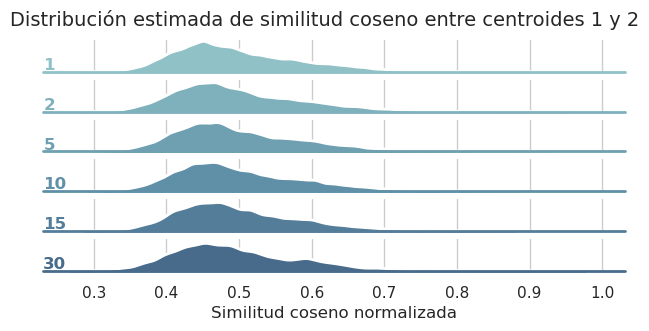

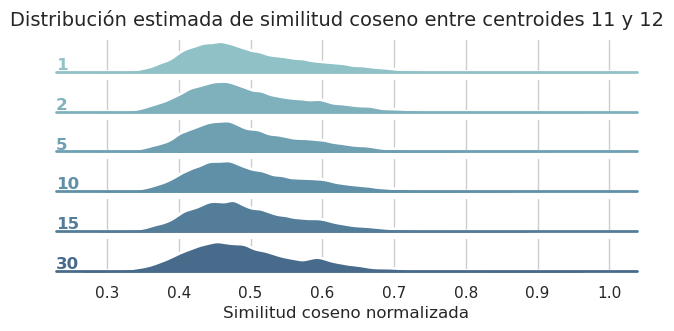

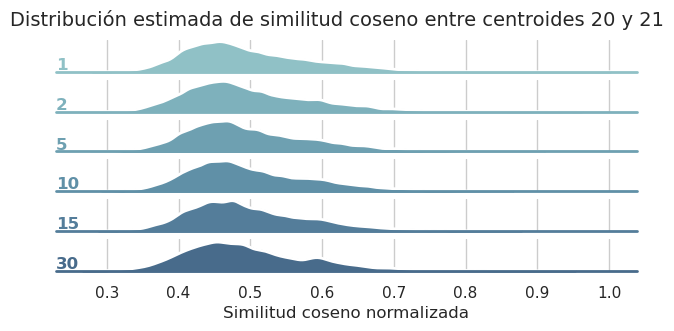

In [69]:
for k in [0, 10, 19]:
    plot_intercentroid_sim_kde(interclass_similarities, k)

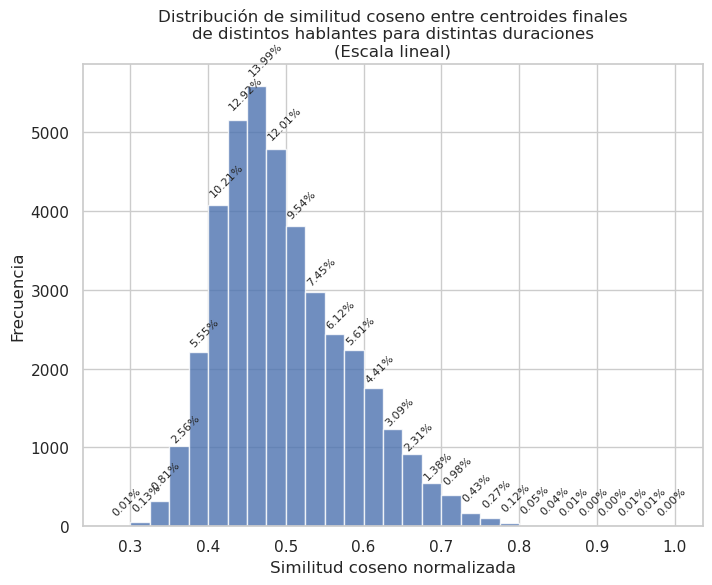

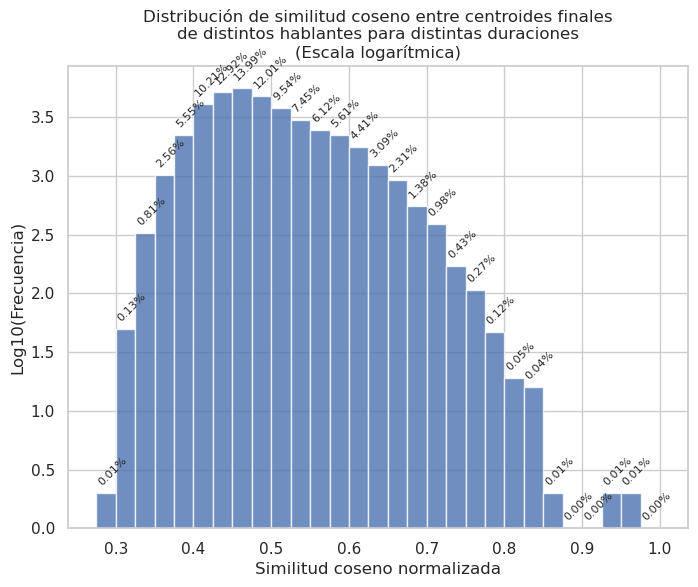

In [87]:
# def plot_intercentroid_sim_kde(interclass_similarities: np.ndarray, k: int):
#     """
#     Plots a histogram for an element-wise feature in a sequence
#     of centroid evolution.
#     """

bins = np.arange(0.275, 1.001, 0.025)
sims = np.array([])
for d, inter_sim in enumerate(interclass_similarities):
    K, N, _ = inter_sim.shape
    mask = np.triu(np.ones(N, dtype=bool) ^ np.eye(N, dtype=bool))
    last_inter_sim = inter_sim[k]  # Interclass similarities of centroids calculated with k audios
    last_inter_sim = last_inter_sim[mask]
    sims = np.append(sims, last_inter_sim)

counts, bins = np.histogram(sims, bins)

sns.set_style('whitegrid')
# sns.set_style('white')

# Linear scale histogram with percentages
plt.figure(figsize=(8, 6))
plt.title(f'Distribución de similitud coseno entre centroides finales\nde distintos hablantes para distintas duraciones\n(Escala lineal)')
plt.xlabel('Similitud coseno normalizada')
plt.ylabel('Frecuencia')

plt.bar(bins[:-1], counts, width=0.025, align='edge', alpha=0.8)

# Calculate percentages
percentages = counts / np.sum(counts) * 100

# Plot percentages without overlap and with rotation
rotation_angle = 45  # Set the desired rotation angle

for bin_edge, cnt, pct in zip(bins[:-1], counts, percentages):
    if cnt > 0:
        text_y = cnt + (max(counts) * 0.02 if cnt < 500 else cnt * 0.02)  # Adjust vertical position for low counts
        # plt.text(bin_edge + 0.0125, text_y, f'{pct:.2f}%', ha='center', va='bottom', fontsize=8, rotation=rotation_angle)
        plt.text(bin_edge, text_y, f'{pct:.2f}%', ha='left', va='bottom', fontsize=8, rotation=rotation_angle)
    

# Log scale histogram with percentages
counts[counts == 0] = 1  # Avoid calculation of log(0)

plt.figure(figsize=(8, 6))
plt.title(f'Distribución de similitud coseno entre centroides finales\nde distintos hablantes para distintas duraciones\n(Escala logarítmica)')
plt.xlabel('Similitud coseno normalizada')
plt.ylabel('Log10(Frecuencia)')

plt.bar(bins[:-1], np.log10(counts), width=0.025, align='edge', alpha=0.8)


# Plot percentages without overlap and with rotation
rotation_angle = 45  # Set the desired rotation angle

for bin_edge, cnt, pct in zip(bins[:-1], counts, percentages):
    if cnt > 0:
        text_y = np.log10(cnt) + 0.05  # Adjust vertical position for low counts
        # plt.text(bin_edge + 0.0125, text_y, f'{pct:.2f}%', ha='center', va='bottom', fontsize=8, rotation=rotation_angle)
        plt.text(bin_edge, text_y, f'{pct:.2f}%', ha='left', va='bottom', fontsize=8, rotation=rotation_angle)
    

    


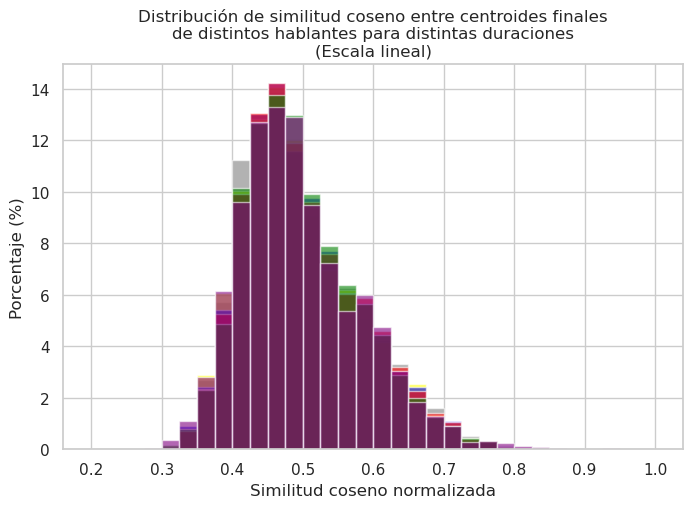

In [25]:
percentages = []
bins = np.arange(0.2, 1.01, 0.025)
for inter_sim in interclass_similarities:
    K, N, _ = inter_sim.shape
    mask = np.triu(np.ones(N, dtype=bool) ^ np.eye(N, dtype=bool))
    last_inter_sim = inter_sim[-1]  # Interclass similarities of centroids calculated with K=20 audios
    last_inter_sim = last_inter_sim[mask]
    counts, _ = np.histogram(last_inter_sim, bins)
    pctg = counts / np.sum(counts) * 100
    percentages.append(pctg)

sns.set_style('whitegrid')

# Linear scale histogram with percentages
plt.figure(figsize=(8, 5))
plt.title(f'Distribución de similitud coseno entre centroides finales\nde distintos hablantes para distintas duraciones\n(Escala lineal)')
plt.xlabel('Similitud coseno normalizada')
plt.ylabel('Porcentaje (%)')

plt.bar(bins[:-1], percentages[0], width=0.025, align='edge', alpha=0.6, label='1 seg', color='gray')
plt.bar(bins[:-1], percentages[1], width=0.025, align='edge', alpha=0.6, label='2 seg', color='yellow')
plt.bar(bins[:-1], percentages[2], width=0.025, align='edge', alpha=0.6, label='5 seg', color='blue')
plt.bar(bins[:-1], percentages[3], width=0.025, align='edge', alpha=0.6, label='10 seg', color='red')
plt.bar(bins[:-1], percentages[4], width=0.025, align='edge', alpha=0.6, label='15 seg', color='green')
plt.bar(bins[:-1], percentages[5], width=0.025, align='edge', alpha=0.6, label='30 seg', color='purple')

plt.show()


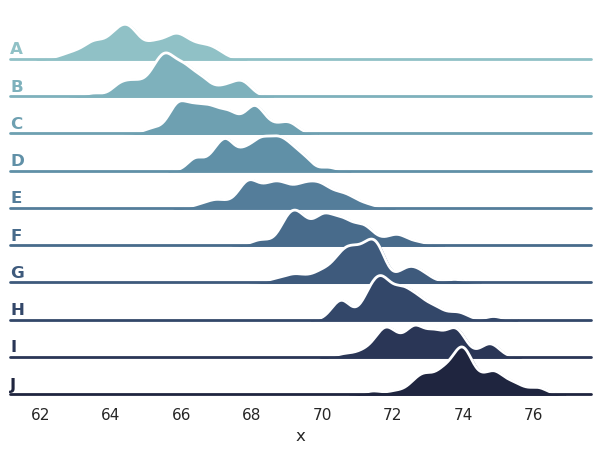

In [29]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Create the data
rs = np.random.RandomState(1979)
x = rs.randn(500)
g = np.tile(list("ABCDEFGHIJ"), 50)
df = pd.DataFrame(dict(x=x, g=g))
m = df.g.map(ord)
df["x"] += m

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(df, row="g", hue="g", aspect=15, height=.5, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "x",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "x", clip_on=False, color="w", lw=2, bw_adjust=.5)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "x")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

---
## 4) Interclass distribution with respect to own centroids

In [31]:
# Create a mask for the upper triangle
interclass_similarities = get_interclass_similarities(centroids[-1])
m = interclass_similarities[-1]

mask = np.triu(np.ones_like(m, dtype=bool))
plt.figure(figsize=(10, 10))
# Set the upper triangle to NaN
# m[mask] = np.nan
sns.set_style('white')
sns.heatmap(m, cmap="viridis", cbar_kws={'label': 'Cosine Similarity'}, mask=mask, square=True)

plt.show()

NameError: name 'centroids' is not defined

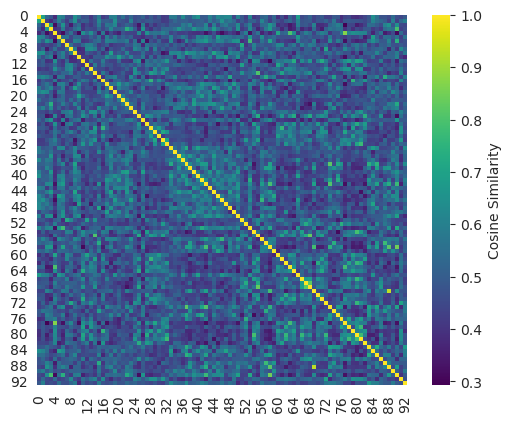

In [ ]:
sns.heatmap(interclass_similarities[-1], cmap="viridis", cbar_kws={'label': 'Cosine Similarity'}, square=True)
plt.show()

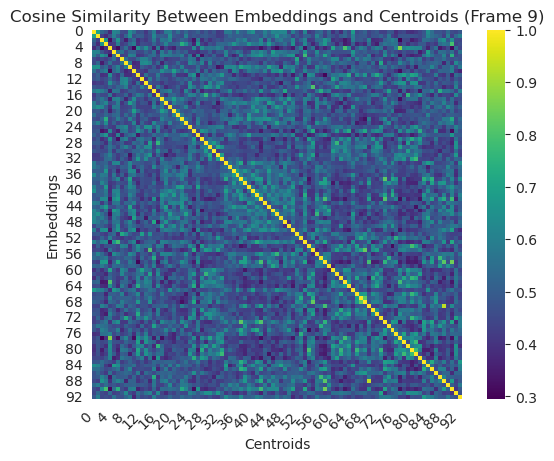

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Example data: List of 2D arrays representing heatmap data at different time points
# Assuming interclass_similarities is already defined as in your example

# Set up the figure and axis
fig, ax = plt.subplots()

# Create a mask for the upper triangle

# mask = np.triu(np.ones_like(m, dtype=bool))

# Initialize the heatmap
heatmap = sns.heatmap(interclass_similarities[0], cmap='viridis', square=True,
                      # mask=mask,
                      cbar=True, ax=ax)

# Set axis labels and title
ax.set_title('Cosine Similarity Between Embeddings and Centroids')
ax.set_xlabel('Centroids')
ax.set_ylabel('Embeddings')

# Customize tick labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

# Get the QuadMesh object from the heatmap
quadmesh = ax.collections[0]

# Function to update the heatmap
def update(k):
    quadmesh.set_array(interclass_similarities[k].flatten())
    ax.set_title(f'Cosine Similarity Between Embeddings and Centroids (Frame {k})')
    return quadmesh,

# Create the animation
ani = FuncAnimation(fig, update, frames=len(interclass_similarities), blit=False)

# Save the animation or display it
ani.save('heatmap_animation.mp4', writer='ffmpeg', fps=5)
plt.show()

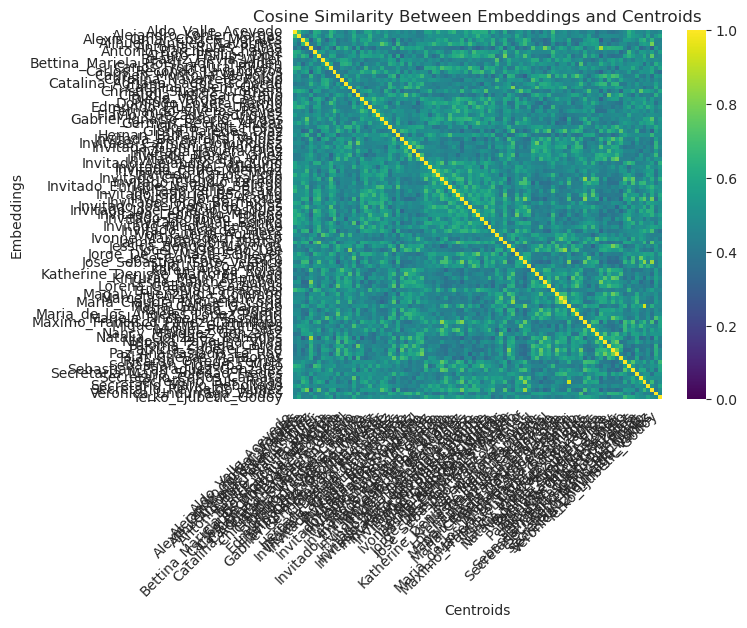

In [ ]:
ax = sns.heatmap(interclass_similarities[-1], cmap='viridis', square=True,
                 vmin=0, vmax=1, xticklabels=valid_labels, yticklabels=valid_labels)
ax.set_title('Cosine Similarity Between Embeddings and Centroids')
ax.set_xlabel('Centroids')
ax.set_ylabel('Embeddings')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

In [ ]:
centroids.shape
last_centroids = centroids[:, -1]
last_centroids.shape

(93, 192)

In [ ]:
last_centroids[0].shape

(192,)

In [ ]:
last_centroids = centroids[:, -1]
embedding_own_centroid = []

for n in range(N):
    speaker_embs = embeddings[labels == n]
    cen = last_centroids[n]
    for emb in speaker_embs:
        sim = cosine_similarity(emb, cen)
        embedding_own_centroid.append(sim)

embedding_own_centroid = np.array(embedding_own_centroid)

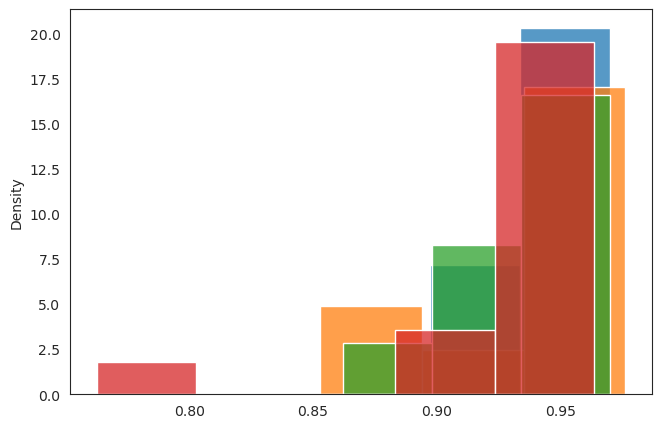

In [ ]:
plt.figure(figsize=(7.5, 5))

for n in range(4):
    speaker_embs = embedding_own_centroid[labels == n]
    sns.histplot(speaker_embs, stat='density', binwidth=0.04)


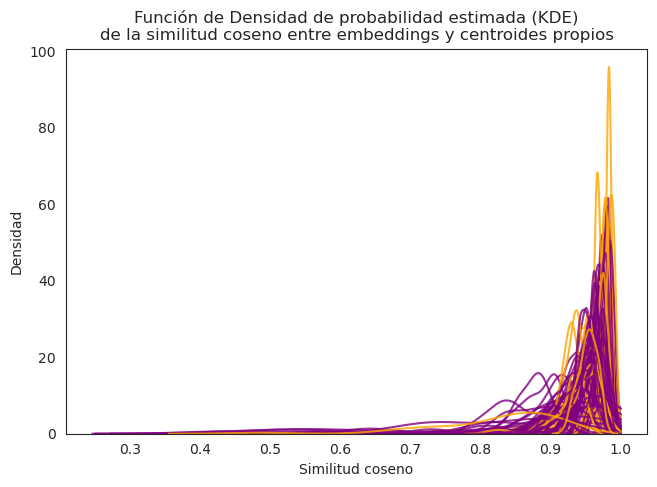

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(7.5, 5))

# Add a title and labels
plt.title('Función de Densidad de probabilidad estimada (KDE)\nde la similitud coseno entre embeddings y centroides propios')
plt.xlabel('Similitud coseno')
plt.ylabel('Densidad')
domain = (0,1)


for n in range(N):
    speaker = valid_labels[n]
    color = 'orange' if speaker in male else 'purple'
    speaker_embs = embedding_own_centroid[labels == n]
    # Create a KDE plot
    
    sns.kdeplot(speaker_embs, bw_adjust=1, fill=False, clip=domain, color=color, alpha=0.8)
# Show the plot
plt.show()

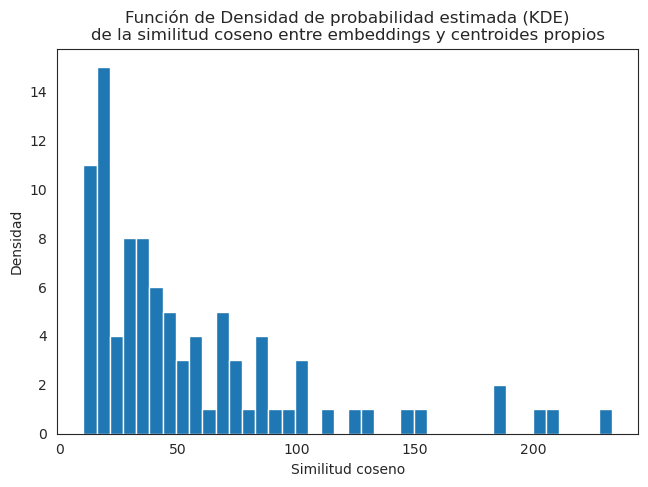

In [ ]:
plt.figure(figsize=(7.5, 5))

# Add a title and labels
plt.title('Función de Densidad de probabilidad estimada (KDE)\nde la similitud coseno entre embeddings y centroides propios')
plt.xlabel('Similitud coseno')
plt.ylabel('Densidad')
domain = (0,1)

a = [i for i in range(N)]
counts = [np.sum(labels == n) for n in range(N)]

bins = plt.hist(counts, bins=40)
plt.show()

In [ ]:
bins

(array([11., 15.,  4.,  8.,  8.,  6.,  5.,  3.,  4.,  1.,  5.,  3.,  1.,
         4.,  1.,  1.,  3.,  0.,  1.,  0.,  1.,  1.,  0.,  0.,  1.,  1.,
         0.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,
         1.]),
 array([ 10.   ,  15.575,  21.15 ,  26.725,  32.3  ,  37.875,  43.45 ,
         49.025,  54.6  ,  60.175,  65.75 ,  71.325,  76.9  ,  82.475,
         88.05 ,  93.625,  99.2  , 104.775, 110.35 , 115.925, 121.5  ,
        127.075, 132.65 , 138.225, 143.8  , 149.375, 154.95 , 160.525,
        166.1  , 171.675, 177.25 , 182.825, 188.4  , 193.975, 199.55 ,
        205.125, 210.7  , 216.275, 221.85 , 227.425, 233.   ]),
 <BarContainer object of 40 artists>)

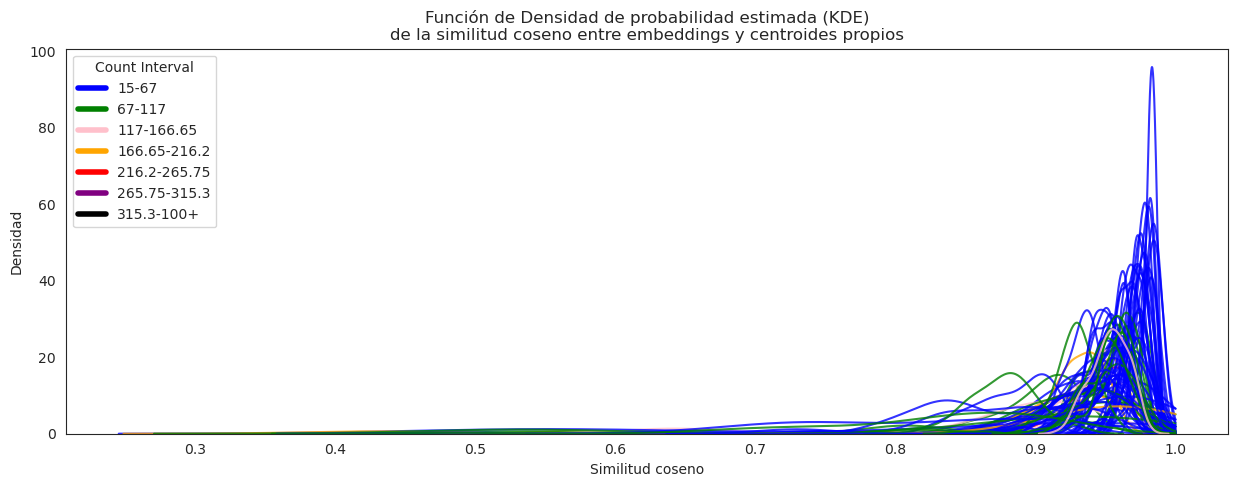

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(15, 5))

# Add a title and labels
plt.title('Función de Densidad de probabilidad estimada (KDE)\nde la similitud coseno entre embeddings y centroides propios')
plt.xlabel('Similitud coseno')
plt.ylabel('Densidad')
domain = (0, 1)

# Define intervals and their corresponding colors
intervals = [
    (15, 67, 'b'),
    (67, 117, 'g'),
    (117, 166.65, 'pink'),
    (166.65, 216.2 , 'orange'),
    (216.2 , 265.75, 'r'),
    (265.75, 315.3 , 'purple'),
    # (60, 70, 'brown'),
    # (70, 80, 'pink'),
    # (80, 90, 'cyan'),
    # (90, 100, 'm'),
    (315.3 , float('inf'), 'k')  # Catch-all for counts >= 100
]

# Plot KDE with colors based on the count interval
for n in range(N):
    speaker = valid_labels[n]
    count = np.sum(labels == n)
    for start, end, color in intervals:
        if start <= count < end:
            speaker_embs = embedding_own_centroid[labels == n]
            sns.kdeplot(speaker_embs, bw_adjust=1, fill=False, clip=domain, color=color, alpha=0.8)
            break

# Create custom legend
handles = [plt.Line2D([0], [0], color=color, lw=4) for _, _, color in intervals]
lbls = [f'{start}-{end if end != float("inf") else "100+"}' for start, end, _ in intervals]
plt.legend(handles, lbls, title='Count Interval')

# Show the plot
plt.show()

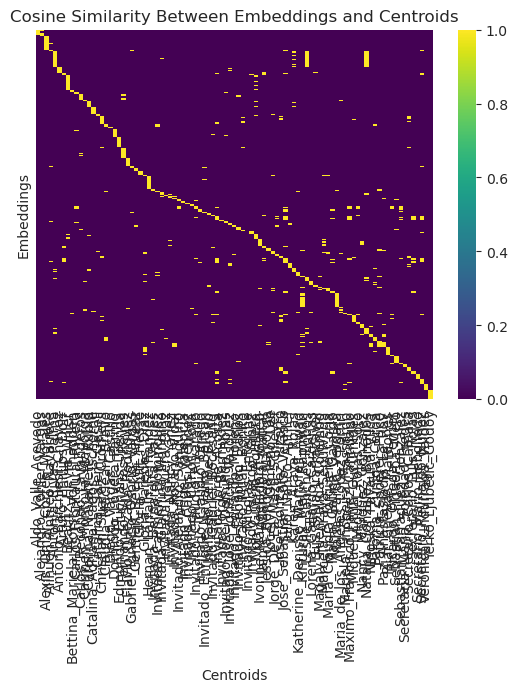

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# plt.figure(figsize=(20, 40))  # Adjust the size to handle the large matrix
ax = sns.heatmap(similarity_matrix >.7, cmap='viridis', xticklabels=embeddings_by_label.keys(), yticklabels=False)
ax.set_title('Cosine Similarity Between Embeddings and Centroids')
ax.set_xlabel('Centroids')
ax.set_ylabel('Embeddings')
plt.show()

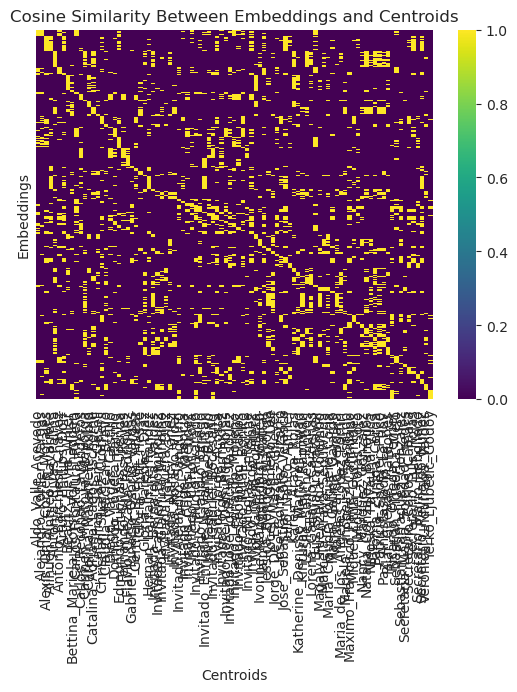

In [ ]:
# plt.figure(figsize=(20, 40))  # Adjust the size to handle the large matrix
ax = sns.heatmap(np.abs(similarity_matrix)>.6, cmap='viridis', xticklabels=embeddings_by_label.keys(), yticklabels=False)
ax.set_title('Cosine Similarity Between Embeddings and Centroids')
ax.set_xlabel('Centroids')
ax.set_ylabel('Embeddings')
plt.show()

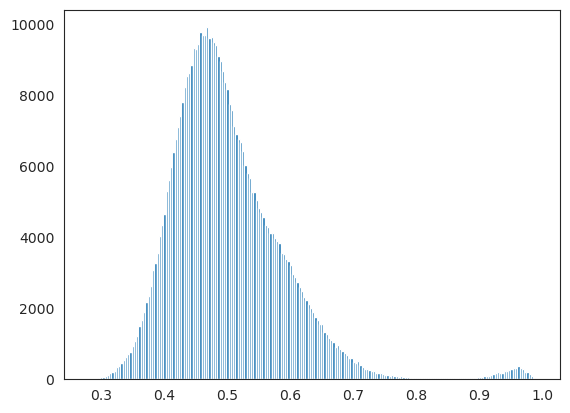

In [ ]:
plt.hist((similarity_matrix).reshape(-1), bins=200);
# plt.yscale("log")

In [ ]:
a = np.vstack(all_embeddings)

NameError: name 'all_embeddings' is not defined

In [ ]:
a

array([[-0.06897517, -0.05414196,  0.06097658, ..., -0.0272247 ,
         0.06051932, -0.04344228],
       [ 0.0395584 , -0.05582495,  0.04575963, ...,  0.03368031,
        -0.06320056, -0.01052512],
       [ 0.05373601, -0.01926537,  0.058074  , ..., -0.06986475,
        -0.1131865 , -0.0717617 ],
       ...,
       [ 0.0434302 , -0.01863375,  0.11141832, ...,  0.05687591,
        -0.01010055,  0.04494489],
       [ 0.07610386, -0.04430066,  0.05074406, ...,  0.08349352,
        -0.07788533,  0.02240222],
       [ 0.02174916, -0.01224554,  0.07873227, ...,  0.15053266,
        -0.0509986 ,  0.01316411]], dtype=float32)

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components=2)
c = pca.fit_transform(np.log(np.abs(a)))

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
b = tsne.fit_transform(a)
a.shape

<ipython-input-69-ddf4dadee454>:3: RuntimeWarning: invalid value encountered in log
  b = tsne.fit_transform(np.log(a))


ValueError: Input X contains NaN.
TSNE does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
!pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 3.0 MB/s eta 0:00:00


In [ ]:
import umap

reducer = umap.UMAP()
u = reducer.fit_transform(a)


AttributeError: module 'umap' has no attribute 'UMAP'

In [ ]:
classes = [[e for _ in range(len(embeddings[e]))] for e in embeddings]
classes_result = []
for i in classes:
  classes_result += i
# Create a color map from unique string labels to colors
unique_classes = list(np.unique(classes_result))
colors = plt.cm.jet(np.linspace(0, 1, len(unique_classes)))  # Generate as many colors as there are unique classes
color_map = dict(zip(unique_classes, colors))

# Map the string labels to colors
class_colors = [color_map[cls] for cls in classes_result]


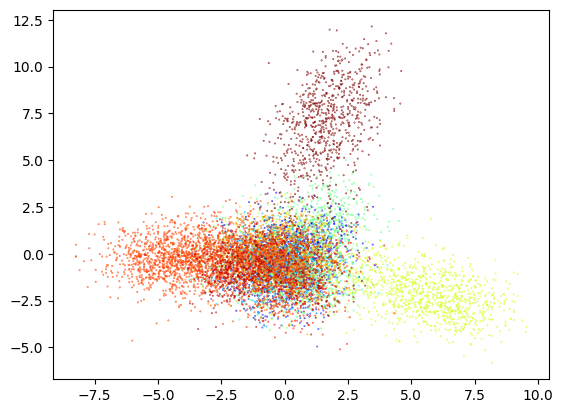

In [ ]:

plt.scatter(*c.T,  color=class_colors, s=.1)

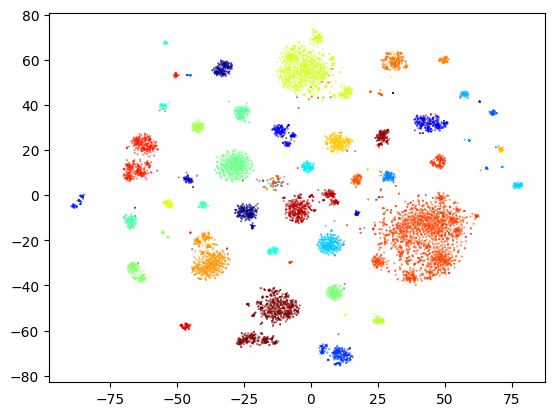

In [ ]:
plt.scatter(*b.T,  color=class_colors, s=.1)